In [1]:
import pandas as pd
import numpy as np
import decoupler as dc
import seaborn as sns
import gseapy as gp
import matplotlib.pyplot as plt
import matplotlib
import json
import scipy as sp
from plot_lib import plot_bubbles, plot_enrich
from plotnine import ggsave
import scanpy as sc
%load_ext autoreload
%autoreload 2

In [2]:
#Okabe- Ito palette
pal = ["#000000", "#E69F00", "#56B4E9", "#009E73", "#F5C710", "#0072B2", "#D55E00", "#CC79A7", "#999999"]

# define top and bottom colormaps 
top = plt.get_cmap('Oranges_r', 128) # r means reversed version
bottom = plt.get_cmap('Blues', 128)# combine it all
newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))# create a new colormaps with a name of OrangeBlue
orange_blue = matplotlib.colors.ListedColormap(newcolors, name='OrangeBlue')

In [3]:
color_pal = {}
for x in zip(["CollecTri", "M2Kb_K-562", "M2Kb_MCF-7", "M2Kb_HepG2", "M2Kb_GM-12878", "CA_K-562", "CA_MCF-7", "CA_HepG2", "CA_GM-12878"], 
             [pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]]):
    color_pal[x[0]] = matplotlib.colors.to_rgba(x[1])
    
cmap = matplotlib.colors.ListedColormap([pal[7], pal[2], pal[3], pal[4], pal[8], pal[1], pal[0], pal[5], pal[6]])
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}

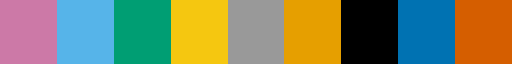

In [4]:
cmap

Network data loading

In [5]:
collectri = dc.get_collectri(organism='human', split_complexes=False)

In [6]:
chip_atlas_k562 = pd.read_table("../data/regulons/ChIP-Atlas_target_genes_K562.tsv", sep="\t")

In [7]:
chip_atlas_k562.head()

,tf,Target_genes
0,ADNP,TRMT2A
1,ADNP,RANBP1
2,ADNP,OSCAR
3,ADNP,NDUFA3
4,ADNP,PSMD9


In [8]:
k562 = pd.read_table("../data/regulons/TF_target_mapping_filtered_merged_K562_with_ppi_with_dnase_with_atac_with_motifs_with_ccres_cleaned.tsv", sep="\t")

k562 = k562.loc[k562.is_M2Kb & (k562.is_pls | k562.is_pels | k562.is_dels), ["tf", "gene_symbol"]].drop_duplicates(["tf", "gene_symbol"])
k562 = k562.loc[k562.tf.isin(collectri.source) & k562.tf.isin(chip_atlas_k562.tf)]

In [9]:
chip_atlas_k562 = chip_atlas_k562.loc[chip_atlas_k562.tf.isin(k562.tf)]
chip_atlas_k562["weight"] = 1
k562["weight"] = 1

In [10]:
collectri = collectri[collectri.source.isin(k562.tf)]

### Prepare cosmic

In [11]:
COSMIC = dc.get_resource('CancerGeneCensus')

COSMIC.tumour_types_somatic = COSMIC.tumour_types_somatic.str.split(";")

COSMIC = COSMIC.explode("tumour_types_somatic")
cosmic_dict = {}
for typ in COSMIC.tumour_types_somatic.drop_duplicates():
    if COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.shape[0] > 1:
        cosmic_dict[typ] = COSMIC.loc[COSMIC.tumour_types_somatic == typ].genesymbol.to_list()

# AML integrated dataset

### C6 healthy vs leukemic cells original

In [12]:
data = pd.read_csv("../data/case_study/c6_leukemic_vs_healthy_aml_dataset.csv", sep=";", index_col=0)
data = data[data["n patients significant (consistent sign)"] > 0]
data

,n patients up,n patients down,Mean log2 Fold Change,SD log2 FC,Sum of log p values,n patients significant (consistent sign),Metadata: Rodriguez-Fraticelli,Metadata: Zhang
Gene,,,,,,,,
BST2,5,0,"1,7700744366",1,25,5,Other,dHSC
CFD,0,5,"-1,5632001468",1,17,5,Other,Other
IFITM3,5,0,"1,3214619090",1,22,5,dHSC,Other
ALDH1A1,4,0,"1,1047309844",1,20,4,dHSC,Other
AVP,4,0,"2,8423696458",1,29,4,Other,dHSC
...,...,...,...,...,...,...,...,...
ZNF700,0,1,"-0,2931881000",0,5,1,Other,Other
ZNF71,0,1,"-0,5398466000",0,3,1,Other,Other
ZNF711,1,0,"0,4326568000",0,6,1,Other,Other


In [13]:
de_genes = data.loc[data["n patients significant (consistent sign)"] > 0]["Mean log2 Fold Change"].str.replace(",",'.').astype("float").to_frame()
de_genes.head()
de_genes["leukemic"] = de_genes["Mean log2 Fold Change"]
#de_genes = de_genes[de_genes["Mean log2 Fold Change"].abs() > 1]

In [14]:
de_genes

,Mean log2 Fold Change,leukemic
Gene,,
BST2,1.770074,1.770074
CFD,-1.563200,-1.563200
IFITM3,1.321462,1.321462
ALDH1A1,1.104731,1.104731
AVP,2.842370,2.842370
...,...,...
ZNF700,-0.293188,-0.293188
ZNF71,-0.539847,-0.539847
ZNF711,0.432657,0.432657


In [16]:
de_genes["pval"] = np.exp(-data["Sum of log p values"] / 5)

In [17]:
de_genes

,Mean log2 Fold Change,leukemic,pval
Gene,,,
BST2,1.770074,1.770074,0.006738
CFD,-1.563200,-1.563200,0.033373
IFITM3,1.321462,1.321462,0.012277
ALDH1A1,1.104731,1.104731,0.018316
AVP,2.842370,2.842370,0.003028
...,...,...,...
ZNF700,-0.293188,-0.293188,0.367879
ZNF71,-0.539847,-0.539847,0.548812
ZNF711,0.432657,0.432657,0.301194


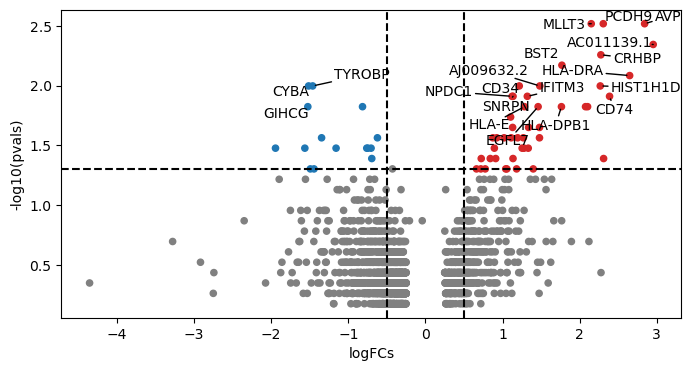

In [18]:
dc.plot_volcano_df(
    de_genes,
    x='Mean log2 Fold Change',
    y='pval',
    top=20,
    figsize=(8, 4)
)
plt.show()

In [19]:
#enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET")
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,leukemia,357/1941,3.159457e-26,2.549998e-22,0,0,2.034541,119.461762,EIF4A2;EIF4A1;APP;SPI1;RNH1;TES;MTRR;TFRC;MLC1...
1,DisGeNET,"Leukemia, Myelocytic, Acute",310/1703,6.370214e-22,2.570700e-18,0,0,1.980834,96.675083,ATF1;APP;SPI1;TFRC;MLC1;ACTB;UBASH3B;MYC;NAMPT...
2,DisGeNET,Breast Carcinoma,699/4963,2.574359e-17,6.925885e-14,0,0,1.525599,58.275371,CYFIP2;TES;RNH1;TFRC;RPL31;GPATCH2;HNRNPU;STMN...
3,DisGeNET,Malignant neoplasm of breast,703/5054,4.218126e-16,8.511125e-13,0,0,1.498123,53.036496,CYFIP2;TES;RNH1;TFRC;RPL31;GPATCH2;HNRNPU;STMN...
4,DisGeNET,Liver carcinoma,527/3593,8.803101e-16,1.420997e-12,0,0,1.557189,53.981922,ATF1;RPL30;TFRC;SPINT2;ENO1;SMC4;PREX2;ALCAM;P...
...,...,...,...,...,...,...,...,...,...,...
8066,DisGeNET,Endocardial Cushion Defects,1/50,9.967056e-01,9.971940e-01,0,0,0.168346,0.000556,KRAS
8067,DisGeNET,Night Blindness,6/132,9.968234e-01,9.971940e-01,0,0,0.392016,0.001247,TTC8;CHM;CACNA2D4;DRAM2;HK1;RPGR
8068,DisGeNET,Autosomal recessive retinitis pigmentosa,1/51,9.970616e-01,9.973088e-01,0,0,0.164970,0.000485,RPGR
8069,DisGeNET,Paroxysmal atrial fibrillation,1/66,9.994704e-01,9.995676e-01,0,0,0.126793,0.000067,SH3PXD2A


In [20]:
de_genes = pd.DataFrame(de_genes["leukemic"])

In [21]:
de_genes = de_genes.T

In [22]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
9313,GTF2B,RBFOX2,-0.1727
13289,RBFOX2,SIRT6,-0.1274
13586,CEBPD,RBFOX2,-0.1243
14029,NONO,RBFOX2,-0.1201
14106,E2F1,GATAD2B,-0.1193
...,...,...,...
4,CREM,MAX,0.6051
3,CREM,NEUROD1,0.6063
2,MAX,MAZ,0.6066
1,JUND,NEUROD1,0.6139


In [23]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
2665,E2F4,SP1,-0.0784
2883,SREBF1,TP53,-0.0706
3138,KLF1,SP1,-0.0620
3253,E2F6,SP1,-0.0574
3277,NRF1,TP53,-0.0569
...,...,...,...
4,FOS,JUN,0.5296
3,SMAD1,SMAD5,0.5297
2,USF1,USF2,0.5550
1,CTNNB1,TCF7L2,0.5922


In [24]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat = pd.DataFrame()

In [25]:
de_genes

Gene,BST2,CFD,IFITM3,ALDH1A1,AVP,BEX2,CD34,CD52,CD74,CRHBP,...,ZNF587,ZNF609,ZNF626,ZNF667-AS1,ZNF672,ZNF700,ZNF71,ZNF711,ZNF724,ZXDC
leukemic,1.770074,-1.5632,1.321462,1.104731,2.84237,1.278789,1.216982,1.54213,2.387688,2.275066,...,-0.458925,-0.525329,0.317175,0.506072,-0.319987,-0.293188,-0.539847,0.432657,-0.38832,-0.27926


K562

In [26]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [27]:
mask = tf_pvals_k562 < 0.05
active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [28]:
active_tfs_k562

['ATF1',
 'ATF3',
 'ATF7',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CBFA2T3',
 'CEBPD',
 'CREB1',
 'CREB3L1',
 'CREB5',
 'CREM',
 'CTBP1',
 'CTCF',
 'CTCFL',
 'E2F1',
 'E2F3',
 'E2F4',
 'E2F6',
 'E2F7',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'ELK1',
 'EP300',
 'ERG',
 'ESRRA',
 'ESRRB',
 'ETS1',
 'EWSR1',
 'FOS',
 'FOSL1',
 'FOXK2',
 'FUS',
 'GABPA',
 'GATA1',
 'GATAD2B',
 'GFI1B',
 'GMEB1',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HDGF',
 'HIF1A',
 'ID3',
 'IRF1',
 'IRF2',
 'JUN',
 'JUND',
 'KDM5B',
 'KLF1',
 'KLF10',
 'KLF13',
 'MAFK',
 'MAX',
 'MAZ',
 'MBD2',
 'MEF2A',
 'MEIS2',
 'MGA',
 'MIER1',
 'MNT',
 'MTA2',
 'MTA3',
 'MXI1',
 'MYBL2',
 'MYC',
 'NEUROD1',
 'NFIX',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2C2',
 'NR2F1',
 'NR2F2',
 'NR4A1',
 'NRF1',
 'PHF20',
 'PHF8',
 'PKNOX1',
 'PLAG1',
 'PML',
 'POU5F1',
 'PRDM10',
 'RB1',
 'REST',
 'RFX1',
 'RLF',
 'RREB1',
 'RUNX1',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SIRT6',
 'SKIL',
 'SMAD1',
 'SMAD5',
 'SMARCA4',
 'SMARCE1',
 'SP1',
 'SP2',
 'SPI1',
 'SREBF1',
 'SRF',
 

In [29]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_k562_activity_m2kb.tsv", sep="\t", index=False)

In [30]:
out_k562.sort_values("p_value")

,score,p_value
ETS1,-6.741124,2.010947e-11
SIN3A,-6.708361,2.506731e-11
GTF2F1,-6.640077,3.955483e-11
THAP1,-6.438087,1.486836e-10
SAP30,-6.352473,2.576751e-10
...,...,...
BRCA1,0.048528,9.613000e-01
PATZ1,-0.033983,9.728935e-01
SMAD2,-0.026892,9.785483e-01
DEAF1,-0.017609,9.859526e-01


In [31]:
active_tfs_k562

['ATF1',
 'ATF3',
 'ATF7',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CBFA2T3',
 'CEBPD',
 'CREB1',
 'CREB3L1',
 'CREB5',
 'CREM',
 'CTBP1',
 'CTCF',
 'CTCFL',
 'E2F1',
 'E2F3',
 'E2F4',
 'E2F6',
 'E2F7',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'ELK1',
 'EP300',
 'ERG',
 'ESRRA',
 'ESRRB',
 'ETS1',
 'EWSR1',
 'FOS',
 'FOSL1',
 'FOXK2',
 'FUS',
 'GABPA',
 'GATA1',
 'GATAD2B',
 'GFI1B',
 'GMEB1',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HDGF',
 'HIF1A',
 'ID3',
 'IRF1',
 'IRF2',
 'JUN',
 'JUND',
 'KDM5B',
 'KLF1',
 'KLF10',
 'KLF13',
 'MAFK',
 'MAX',
 'MAZ',
 'MBD2',
 'MEF2A',
 'MEIS2',
 'MGA',
 'MIER1',
 'MNT',
 'MTA2',
 'MTA3',
 'MXI1',
 'MYBL2',
 'MYC',
 'NEUROD1',
 'NFIX',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2C2',
 'NR2F1',
 'NR2F2',
 'NR4A1',
 'NRF1',
 'PHF20',
 'PHF8',
 'PKNOX1',
 'PLAG1',
 'PML',
 'POU5F1',
 'PRDM10',
 'RB1',
 'REST',
 'RFX1',
 'RLF',
 'RREB1',
 'RUNX1',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SIRT6',
 'SKIL',
 'SMAD1',
 'SMAD5',
 'SMARCA4',
 'SMARCE1',
 'SP1',
 'SP2',
 'SPI1',
 'SREBF1',
 'SRF',
 

In [32]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_m2kb_k562.tsv", sep="\t", index=False)

In [33]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [34]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [35]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [36]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,-1.078251,0.281042,M2Kb_K-562
ARHGAP35,0.232683,0.816030,M2Kb_K-562
ARID1B,-0.423085,0.672276,M2Kb_K-562
ARID3A,-0.597754,0.550067,M2Kb_K-562
ARID3B,-0.638854,0.522986,M2Kb_K-562
...,...,...,...
ZNF436,-1.896163,0.058072,M2Kb_K-562
ZNF444,-1.736354,0.082644,M2Kb_K-562
ZNF76,-2.023865,0.043107,M2Kb_K-562
ZNF77,-0.387900,0.698128,M2Kb_K-562


CollecTri

In [37]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight="weight")
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [38]:
mask_ctri = tf_pvals_ctri < 0.05
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

NFE2      -4.751493
MITF      -4.227231
KLF1      -2.616677
MBD2      -2.575544
LEF1      -2.502891
BHLHE40   -2.246815
ERG       -1.981860
EP300      1.961076
DLX4       1.979575
USF2       2.084898
IKZF1      2.091377
SP1        2.313753
MYC        2.338482
MAFK       2.458096
NFYB       2.532985
CEBPG      2.562517
YBX1       2.735002
NR2C2      2.769127
RELA       2.857900
ATF3       2.941248
MEF2A      2.943967
THRA       3.440546
YY1        3.571998
CREB1      3.624266
IRF1       4.248643
RFX1       5.004245
RFX5       8.666896
Name: leukemic, dtype: float32

In [39]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_collectri.tsv", sep="\t", index=False)

In [40]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [41]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [42]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network
0,DisGeNET,MYELODYSPLASTIC SYNDROME,12/683,2.483659e-11,2.815026e-08,0,0,23.012817,561.943143,YY1;CREB1;DLX4;IRF1;MYC;MBD2;LEF1;EP300;MAFK;E...,CollecTri
1,DisGeNET,"Leukemia, Myelocytic, Acute",16/1703,3.758379e-11,2.815026e-08,0,0,15.766342,378.462332,DLX4;THRA;NFYB;MBD2;LEF1;CEBPG;IKZF1;NR2C2;REL...,CollecTri
2,DisGeNET,Tumor Progression,16/2090,8.099218e-10,4.044209e-07,0,0,12.552994,262.785419,DLX4;MBD2;MITF;RFX1;YBX1;NR2C2;USF2;RELA;YY1;C...,CollecTri
3,DisGeNET,Carcinogenesis,20/4065,2.771367e-09,1.037877e-06,0,0,11.250574,221.680464,MEF2A;THRA;MBD2;LEF1;MITF;RFX1;YBX1;IKZF1;NR2C...,CollecTri
4,DisGeNET,Mammary Neoplasms,16/2387,5.762035e-09,1.726306e-06,0,0,10.798359,204.866198,MEF2A;DLX4;THRA;MBD2;LEF1;YBX1;NR2C2;USF2;RELA...,CollecTri
...,...,...,...,...,...,...,...,...,...,...,...
1493,DisGeNET,Low intelligence,1/947,7.303357e-01,7.322911e-01,0,0,0.773581,0.243099,EP300,CollecTri
1494,DisGeNET,Cognitive delay,1/966,7.375079e-01,7.389878e-01,0,0,0.757593,0.230671,EP300,CollecTri
1495,DisGeNET,Poor school performance,1/985,7.444961e-01,7.454914e-01,0,0,0.742222,0.218991,EP300,CollecTri
1496,DisGeNET,Mental and motor retardation,1/1021,7.572489e-01,7.577547e-01,0,0,0.714668,0.198723,EP300,CollecTri


In [43]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [44]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=False).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,-1.078251,0.281042,M2Kb_K-562
ARHGAP35,0.232683,0.816030,M2Kb_K-562
ARID1B,-0.423085,0.672276,M2Kb_K-562
ARID3A,-0.597754,0.550067,M2Kb_K-562
ARID3B,-0.638854,0.522986,M2Kb_K-562
...,...,...,...
YBX3,1.610058,0.107532,CollecTri
YY1,3.571998,0.000362,CollecTri
ZBED1,-0.267935,0.788775,CollecTri
ZBTB7A,0.141364,0.887595,CollecTri


chip_atlas_k562

In [45]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562 = dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [46]:
tf_pvals_chip_atlas_k562

,ADNP,ARHGAP35,ARID1B,ARID3A,ARID3B,ARNT,ASH1L,ATF1,ATF2,ATF3,...,ZNF274,ZNF281,ZNF316,ZNF384,ZNF395,ZNF436,ZNF444,ZNF76,ZNF77,ZNF79
leukemic,0.141539,0.365135,0.032767,0.738359,0.832478,0.901627,0.084015,0.000399,0.838646,0.02539,...,0.907335,0.003881,0.79207,0.780858,3.620301e-08,0.730939,0.625513,0.506289,0.835525,0.056612


In [47]:
mask_chip_atlas_k562 = tf_pvals_chip_atlas_k562 < 0.05

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask_chip_atlas_k562).sum(axis=0) != 0].index.to_list()

In [48]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas_k562 = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_ca_k562.tsv", sep="\t", index=False)

In [49]:
active_tfs_chip_atlas_k562

['ARID1B',
 'ATF1',
 'ATF3',
 'ATF7',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CEBPD',
 'CEBPZ',
 'CREB1',
 'CREB3L1',
 'CREM',
 'CTBP1',
 'CTCF',
 'CTCFL',
 'CUX1',
 'E2F4',
 'E2F5',
 'E2F6',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'ELK1',
 'EP300',
 'ERG',
 'ESRRA',
 'ETS1',
 'ETV1',
 'FOSL1',
 'GABPA',
 'GATA1',
 'GATAD2B',
 'GFI1B',
 'GMEB1',
 'GTF2B',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HEY1',
 'ID3',
 'IRF1',
 'JUN',
 'JUND',
 'KDM5B',
 'MAX',
 'MAZ',
 'MBD2',
 'MEF2A',
 'MEF2D',
 'MGA',
 'MITF',
 'MNT',
 'MTA3',
 'MXI1',
 'MYC',
 'NCOR1',
 'NEUROD1',
 'NFIC',
 'NFIX',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2C2',
 'NR4A1',
 'NRF1',
 'PHF20',
 'PHF8',
 'PLAG1',
 'PML',
 'PRDM10',
 'RB1',
 'RBFOX2',
 'RCOR1',
 'REST',
 'RFX5',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SIX5',
 'SKIL',
 'SMAD5',
 'SMARCA4',
 'SOX6',
 'SP1',
 'SP2',
 'SPI1',
 'SREBF1',
 'SRF',
 'TAF1',
 'TBP',
 'TEAD1',
 'TFDP1',
 'THAP1',
 'TRIM28',
 'UBTF',
 'USF1',
 'USF2',
 'VEZF1',
 'YY1',
 'ZBTB7A',
 'ZFX',
 'ZNF148',
 'ZNF24',
 'ZNF281',
 'ZNF

In [50]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [51]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [52]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_dhsc_ahsc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [53]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat = pd.concat([megaheat, heat], axis =0)
megaheat

,score,p_value,Network
ADNP,-1.078251,0.281042,M2Kb_K-562
ARHGAP35,0.232683,0.816030,M2Kb_K-562
ARID1B,-0.423085,0.672276,M2Kb_K-562
ARID3A,-0.597754,0.550067,M2Kb_K-562
ARID3B,-0.638854,0.522986,M2Kb_K-562
...,...,...,...
ZNF436,-0.343921,0.730939,CA_K-562
ZNF444,-0.488123,0.625513,CA_K-562
ZNF76,-0.664738,0.506289,CA_K-562
ZNF77,0.207646,0.835525,CA_K-562


Plotting results

In [54]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[1], pal[7], pal[2]]

In [55]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,1.672493e-06,5.159481e-05,0.0,0.0,29.559595,466.219942,5.353600
std,2.651490e-06,7.313444e-05,0.0,0.0,19.474991,328.160378,1.264427
min,5.825182e-10,1.077659e-07,0.0,0.0,14.860500,177.703353,3.802433
25%,8.609804e-08,1.695725e-07,0.0,0.0,15.769731,208.296635,3.854438
50%,9.791422e-08,3.736415e-06,0.0,0.0,16.717981,271.964427,5.427545
75%,2.942151e-06,1.408212e-04,0.0,0.0,55.130266,886.544454,6.770644
max,6.407121e-06,1.576039e-04,0.0,0.0,57.969114,945.958152,6.967519


In [56]:
aml_omim_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,OMIM_Expanded,dystonia,10/94,5.825182e-10,1.077659e-07,0,0,19.465762,413.913347,SMAD1;CREB1;PLAG1;CTBP1;FUS;NR2F1;EP300;FOS;TH...,M2Kb_K-562,6.967519
75,OMIM_Expanded,hermansky-pudlak syndrome,8/85,8.609804e-08,1.695725e-07,0,0,16.717981,271.964427,SMAD1;CREB1;PLAG1;CTBP1;FUS;NR2F1;EP300;FOS,M2Kb_K-562,6.770644
74,OMIM_Expanded,hepatocellular carcinoma,8/85,8.609804e-08,1.695725e-07,0,0,16.717981,271.964427,SMAD1;CREB1;PLAG1;CTBP1;FUS;NR2F1;EP300;FOS,M2Kb_K-562,6.770644
73,OMIM_Expanded,diamond-blackfan anemia,8/85,8.609804e-08,1.695725e-07,0,0,16.717981,271.964427,SMAD1;CREB1;PLAG1;CTBP1;FUS;NR2F1;EP300;FOS,M2Kb_K-562,6.770644
72,OMIM_Expanded,"ceroid-lipofuscinosis, neuronal",8/85,8.609804e-08,1.695725e-07,0,0,16.717981,271.964427,SMAD1;CREB1;PLAG1;CTBP1;FUS;NR2F1;EP300;FOS,M2Kb_K-562,6.770644
0,OMIM_Expanded,bare lymphocyte syndrome,5/83,8.185528e-08,3.736415e-06,0,0,57.969114,945.958152,CREB1;THRA;RFX5;EP300;RELA,CollecTri,5.427545
1,OMIM_Expanded,waardenburg syndrome,5/85,9.230619e-08,3.736415e-06,0,0,56.514205,915.425823,CREB1;THRA;EP300;MITF;RELA,CollecTri,5.427545
2,OMIM_Expanded,albinism,5/86,9.791422e-08,3.736415e-06,0,0,55.813692,900.786900,CREB1;THRA;EP300;MITF;RELA,CollecTri,5.427545
3,OMIM_Expanded,coronary artery disease,5/87,1.037893e-07,3.736415e-06,0,0,55.130266,886.544454,MEF2A;CREB1;THRA;EP300;RELA,CollecTri,5.427545
4,OMIM_Expanded,gastric cancer,5/87,1.037893e-07,3.736415e-06,0,0,55.130266,886.544454,CREB1;THRA;IRF1;EP300;RELA,CollecTri,5.427545


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new.svg


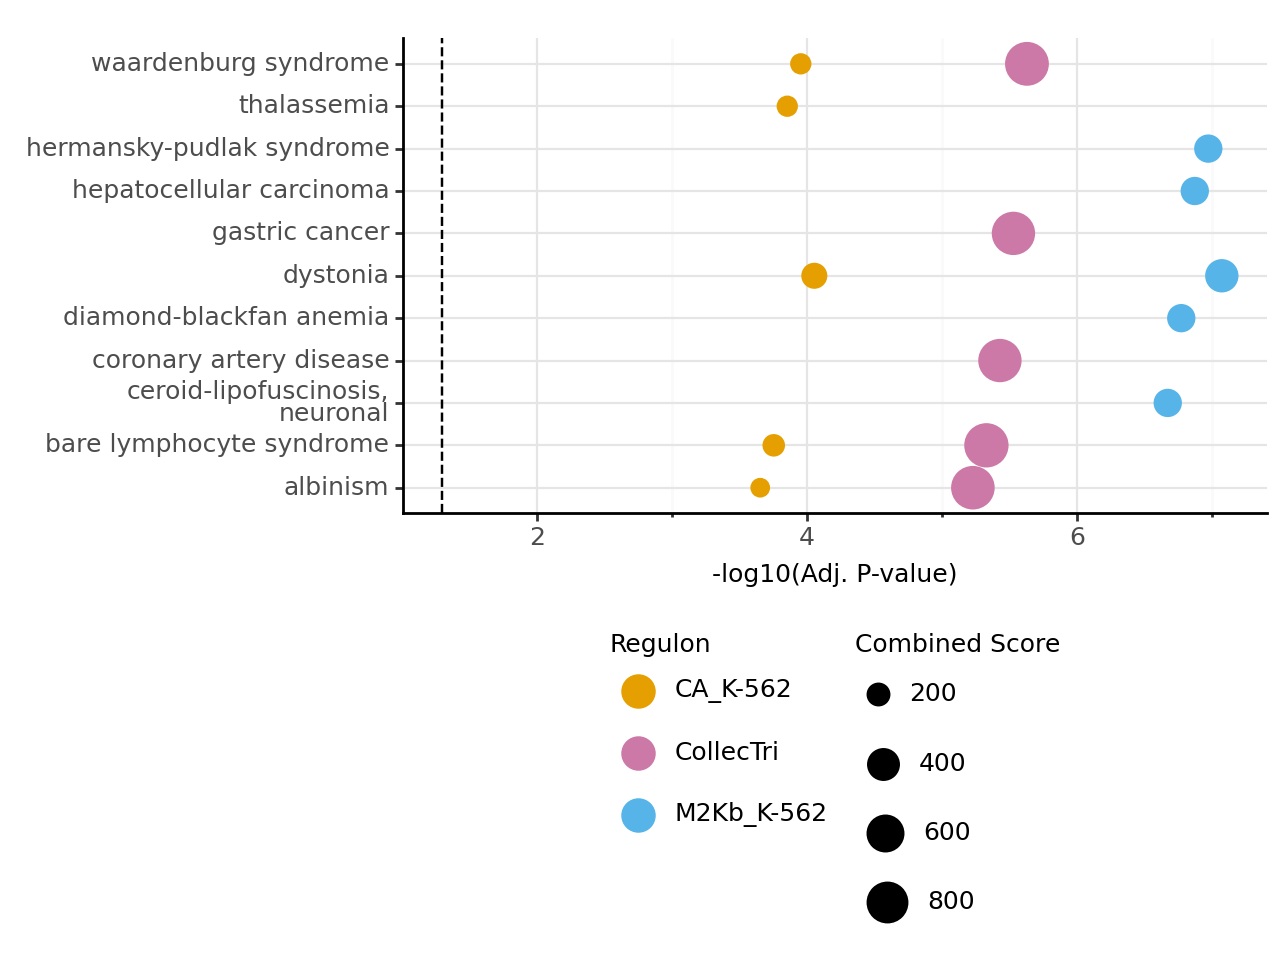

<Figure Size: (640 x 480)>

In [57]:
p = plot_enrich(aml_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [58]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,6.270496e-10,2.149936e-07,0.0,0.0,9.648723,368.739495,15.641460
std,1.595567e-09,5.020762e-07,0.0,0.0,4.671670,141.768497,7.511529
min,4.908466e-33,1.467631e-29,0.0,0.0,5.659732,204.866198,5.762882
25%,2.058354e-24,1.728194e-21,0.0,0.0,6.365108,263.510384,7.550518
50%,5.807200e-20,5.042585e-17,0.0,0.0,8.119889,345.201168,16.297347
75%,3.121019e-11,2.815026e-08,0.0,0.0,11.024466,443.754354,20.765687
max,5.762035e-09,1.726306e-06,0.0,0.0,23.012817,652.972155,28.833383


In [59]:
aml_disreg_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,DisGeNET,Carcinogenesis,90/4065,4.908466e-33,1.467631e-29,0,0,8.777174,652.972155,RB1;ATF1;KDM5B;PHF20;CTCF;ELK1;ETS1;PHF8;YY1;S...,M2Kb_K-562,28.833383
1,DisGeNET,Tumor Progression,62/2090,7.289546e-27,1.089787e-23,0,0,7.904854,475.740631,RB1;KDM5B;SPI1;CTCF;ELK1;ETS1;YY1;SIN3B;CREB3L...,M2Kb_K-562,22.962658
2,DisGeNET,Breast Carcinoma,88/4963,1.521667e-24,1.516595e-21,0,0,6.294440,345.201168,RB1;KDM5B;CTCF;ELK1;ETS1;YY1;SIN3B;ZMIZ1;SIN3A...,M2Kb_K-562,20.819131
3,DisGeNET,Malignant neoplasm of prostate,72/3239,2.595042e-24,1.939794e-21,0,0,6.435776,349.516937,RB1;KDM5B;CTCF;ELK1;ETS1;PHF8;YY1;SIN3B;ZMIZ1;...,M2Kb_K-562,20.712244
4,DisGeNET,Prostate carcinoma,70/3145,1.771921e-23,1.059609e-20,0,0,6.267253,328.325049,RB1;KDM5B;CTCF;ELK1;ETS1;PHF8;YY1;SIN3B;ZMIZ1;...,M2Kb_K-562,19.974854
0,DisGeNET,MYELODYSPLASTIC SYNDROME,12/683,2.483659e-11,2.815026e-08,0,0,23.012817,561.943143,YY1;CREB1;DLX4;IRF1;MYC;MBD2;LEF1;EP300;MAFK;E...,CollecTri,7.550518
1,DisGeNET,"Leukemia, Myelocytic, Acute",16/1703,3.758379e-11,2.815026e-08,0,0,15.766342,378.462332,DLX4;THRA;NFYB;MBD2;LEF1;CEBPG;IKZF1;NR2C2;REL...,CollecTri,7.550518
2,DisGeNET,Tumor Progression,16/2090,8.099218e-10,4.044209e-07,0,0,12.552994,262.785419,DLX4;MBD2;MITF;RFX1;YBX1;NR2C2;USF2;RELA;YY1;C...,CollecTri,6.393166
3,DisGeNET,Carcinogenesis,20/4065,2.771367e-09,1.037877e-06,0,0,11.250574,221.680464,MEF2A;THRA;MBD2;LEF1;MITF;RFX1;YBX1;IKZF1;NR2C...,CollecTri,5.983854
4,DisGeNET,Mammary Neoplasms,16/2387,5.762035e-09,1.726306e-06,0,0,10.798359,204.866198,MEF2A;DLX4;THRA;MBD2;LEF1;YBX1;NR2C2;USF2;RELA...,CollecTri,5.762882


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new.svg


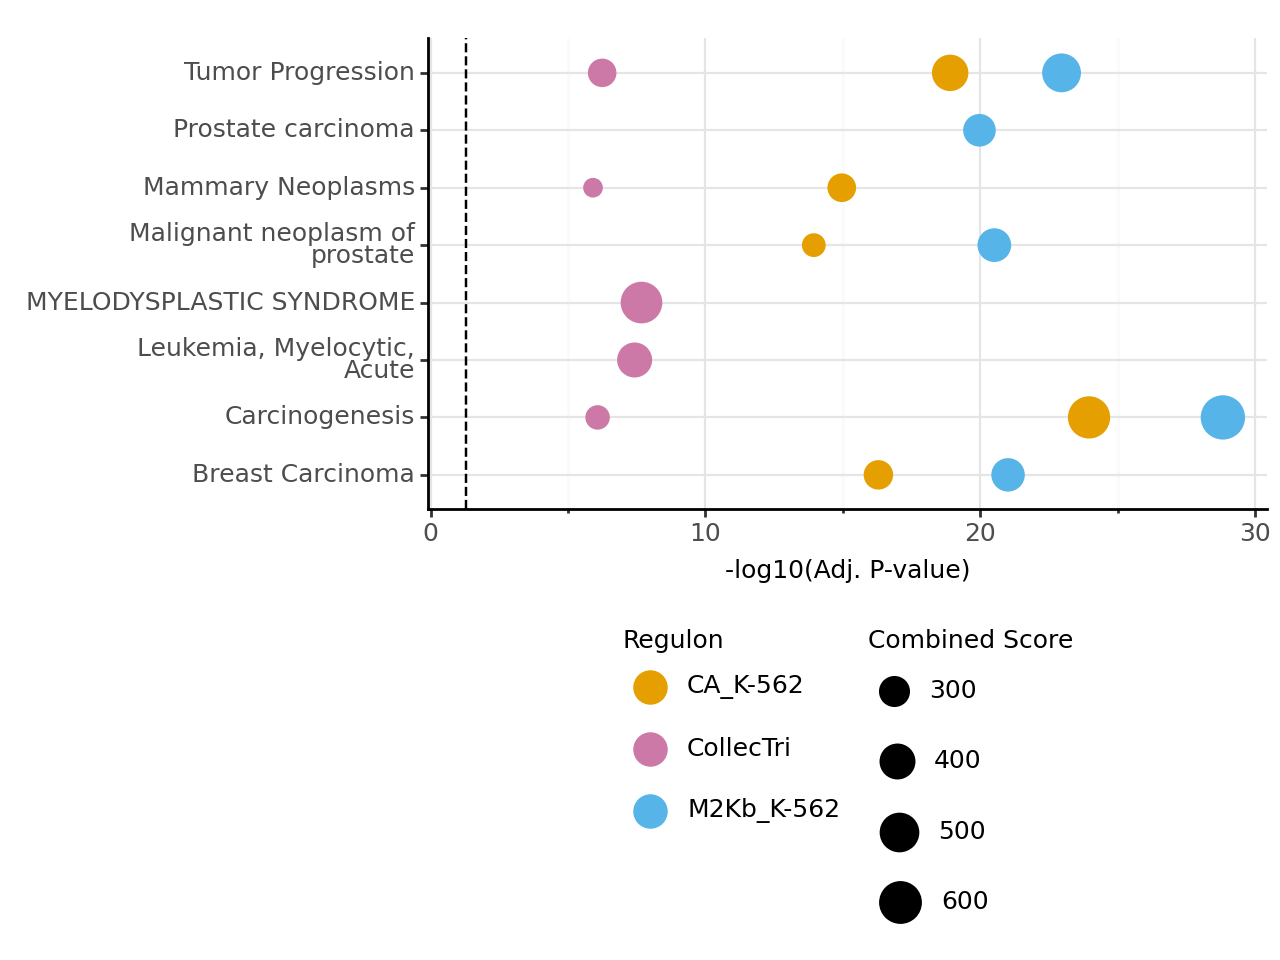

<Figure Size: (640 x 480)>

In [60]:
p = plot_enrich(aml_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [61]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.001748,0.014806,23.210529,167.570177,2.037659
std,0.001502,0.009218,7.029016,71.154092,0.596785
min,0.000023,0.000828,7.805831,54.968830,1.593212
25%,0.000874,0.012458,21.157598,124.658750,1.680712
50%,0.001384,0.017377,21.933798,184.460403,1.760013
75%,0.003402,0.020859,28.022222,207.930607,1.904565
max,0.004056,0.025515,30.756098,290.955620,3.082182


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new.svg


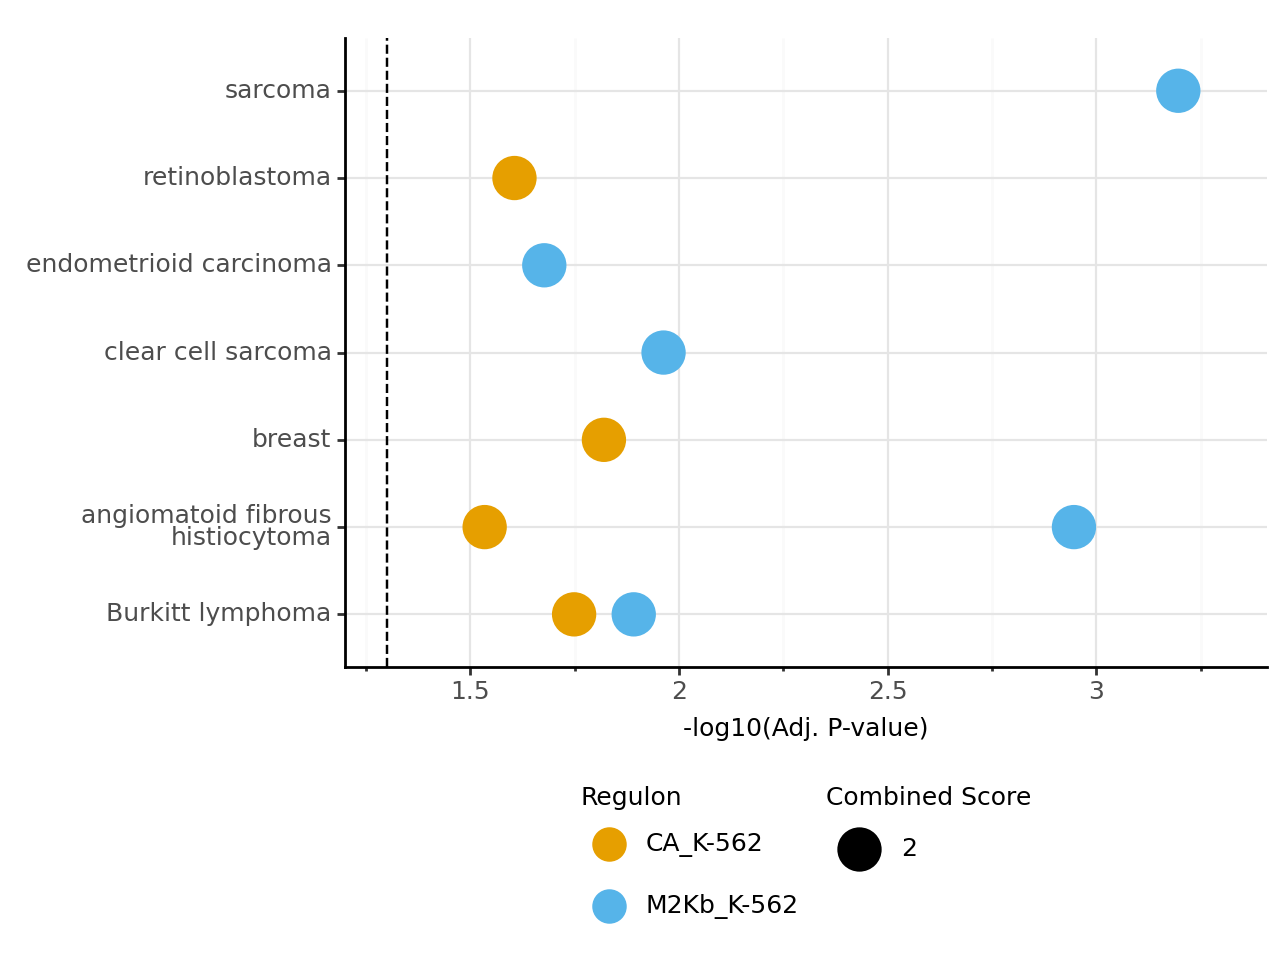

<Figure Size: (640 x 480)>

In [62]:
p = plot_enrich(aml_cosmic_enrich, [ pal[1], pal[2]], size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [63]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,9.000000,9.000000,9.000000,9.000000,9.000000
mean,0.001748,0.014806,23.210529,167.570177,2.037659
std,0.001502,0.009218,7.029016,71.154092,0.596785
min,0.000023,0.000828,7.805831,54.968830,1.593212
25%,0.000874,0.012458,21.157598,124.658750,1.680712
50%,0.001384,0.017377,21.933798,184.460403,1.760013
75%,0.003402,0.020859,28.022222,207.930607,1.904565
max,0.004056,0.025515,30.756098,290.955620,3.082182


In [64]:
megaheat.describe()

,score,p_value
count,607.000000,6.070000e+02
mean,-1.642279,2.700530e-01
std,2.201594,3.171851e-01
min,-6.741618,8.561306e-18
25%,-3.031333,1.891559e-03
50%,-1.376516,9.552337e-02
75%,-0.205917,5.263182e-01
max,8.666896,9.979562e-01


In [65]:
megaheat.to_csv("../data/3-tf_activity/aml_activity_estimates_dhsc_ahsc.tsv", sep="\t", index=False)

In [66]:
megaheat = megaheat[megaheat.p_value < 0.05].sort_values("score")
megaheat["TF"] = megaheat.index
megaheat["log_p"] = - np.log10(megaheat.p_value).round(1)
#megaheat["log_p"] = megaheat["log_p"].astype("str")

In [67]:
print(megaheat[megaheat.Network == "M2Kb_K-562"].sort_values("score").to_string())

            score       p_value     Network       TF  log_p
ETS1    -6.741124  2.010947e-11  M2Kb_K-562     ETS1   10.7
SIN3A   -6.708361  2.506731e-11  M2Kb_K-562    SIN3A   10.6
GTF2F1  -6.640077  3.955483e-11  M2Kb_K-562   GTF2F1   10.4
THAP1   -6.438087  1.486836e-10  M2Kb_K-562    THAP1    9.8
SAP30   -6.352473  2.576751e-10  M2Kb_K-562    SAP30    9.6
BRD4    -6.147527  9.349835e-10  M2Kb_K-562     BRD4    9.0
UBTF    -6.080326  1.414695e-09  M2Kb_K-562     UBTF    8.8
NFYA    -6.045561  1.749831e-09  M2Kb_K-562     NFYA    8.8
MYC     -6.001175  2.291794e-09  M2Kb_K-562      MYC    8.6
HCFC1   -5.980987  2.589470e-09  M2Kb_K-562    HCFC1    8.6
CTCFL   -5.942880  3.257412e-09  M2Kb_K-562    CTCFL    8.5
MAZ     -5.869606  5.044995e-09  M2Kb_K-562      MAZ    8.3
YY1     -5.783080  8.402820e-09  M2Kb_K-562      YY1    8.1
E2F4    -5.777127  8.700736e-09  M2Kb_K-562     E2F4    8.1
NRF1    -5.645102  1.868491e-08  M2Kb_K-562     NRF1    7.7
GFI1B   -5.644853  1.871162e-08  M2Kb_K-

In [68]:
print(megaheat[megaheat.Network == "CollecTri"].sort_values("score").to_string())

            score       p_value    Network       TF  log_p
NFE2    -4.751493  2.152257e-06  CollecTri     NFE2    5.7
MITF    -4.227231  2.464550e-05  CollecTri     MITF    4.6
KLF1    -2.616677  8.941054e-03  CollecTri     KLF1    2.0
MBD2    -2.575544  1.007432e-02  CollecTri     MBD2    2.0
LEF1    -2.502891  1.239180e-02  CollecTri     LEF1    1.9
BHLHE40 -2.246815  2.475264e-02  CollecTri  BHLHE40    1.6
ERG     -1.981860  4.762171e-02  CollecTri      ERG    1.3
EP300    1.961076  4.999873e-02  CollecTri    EP300    1.3
DLX4     1.979575  4.787831e-02  CollecTri     DLX4    1.3
USF2     2.084898  3.719598e-02  CollecTri     USF2    1.4
IKZF1    2.091377  3.661109e-02  CollecTri    IKZF1    1.4
SP1      2.313753  2.077488e-02  CollecTri      SP1    1.7
MYC      2.338482  1.945321e-02  CollecTri      MYC    1.7
MAFK     2.458096  1.404574e-02  CollecTri     MAFK    1.9
NFYB     2.532985  1.137994e-02  CollecTri     NFYB    1.9
CEBPG    2.562517  1.045901e-02  CollecTri    CEBPG    2

In [69]:
megaheat

,score,p_value,Network,TF,log_p
PHF8,-6.741618,2.004255e-11,CA_K-562,PHF8,10.7
ETS1,-6.741124,2.010947e-11,M2Kb_K-562,ETS1,10.7
SIN3A,-6.708361,2.506731e-11,M2Kb_K-562,SIN3A,10.6
GTF2F1,-6.640077,3.955483e-11,M2Kb_K-562,GTF2F1,10.4
MYC,-6.550045,7.170252e-11,CA_K-562,MYC,10.1
...,...,...,...,...,...
YY1,3.571998,3.620332e-04,CollecTri,YY1,3.4
CREB1,3.624266,2.964938e-04,CollecTri,CREB1,3.5
IRF1,4.248643,2.242190e-05,CollecTri,IRF1,4.6
RFX1,5.004245,6.062165e-07,CollecTri,RFX1,6.2


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


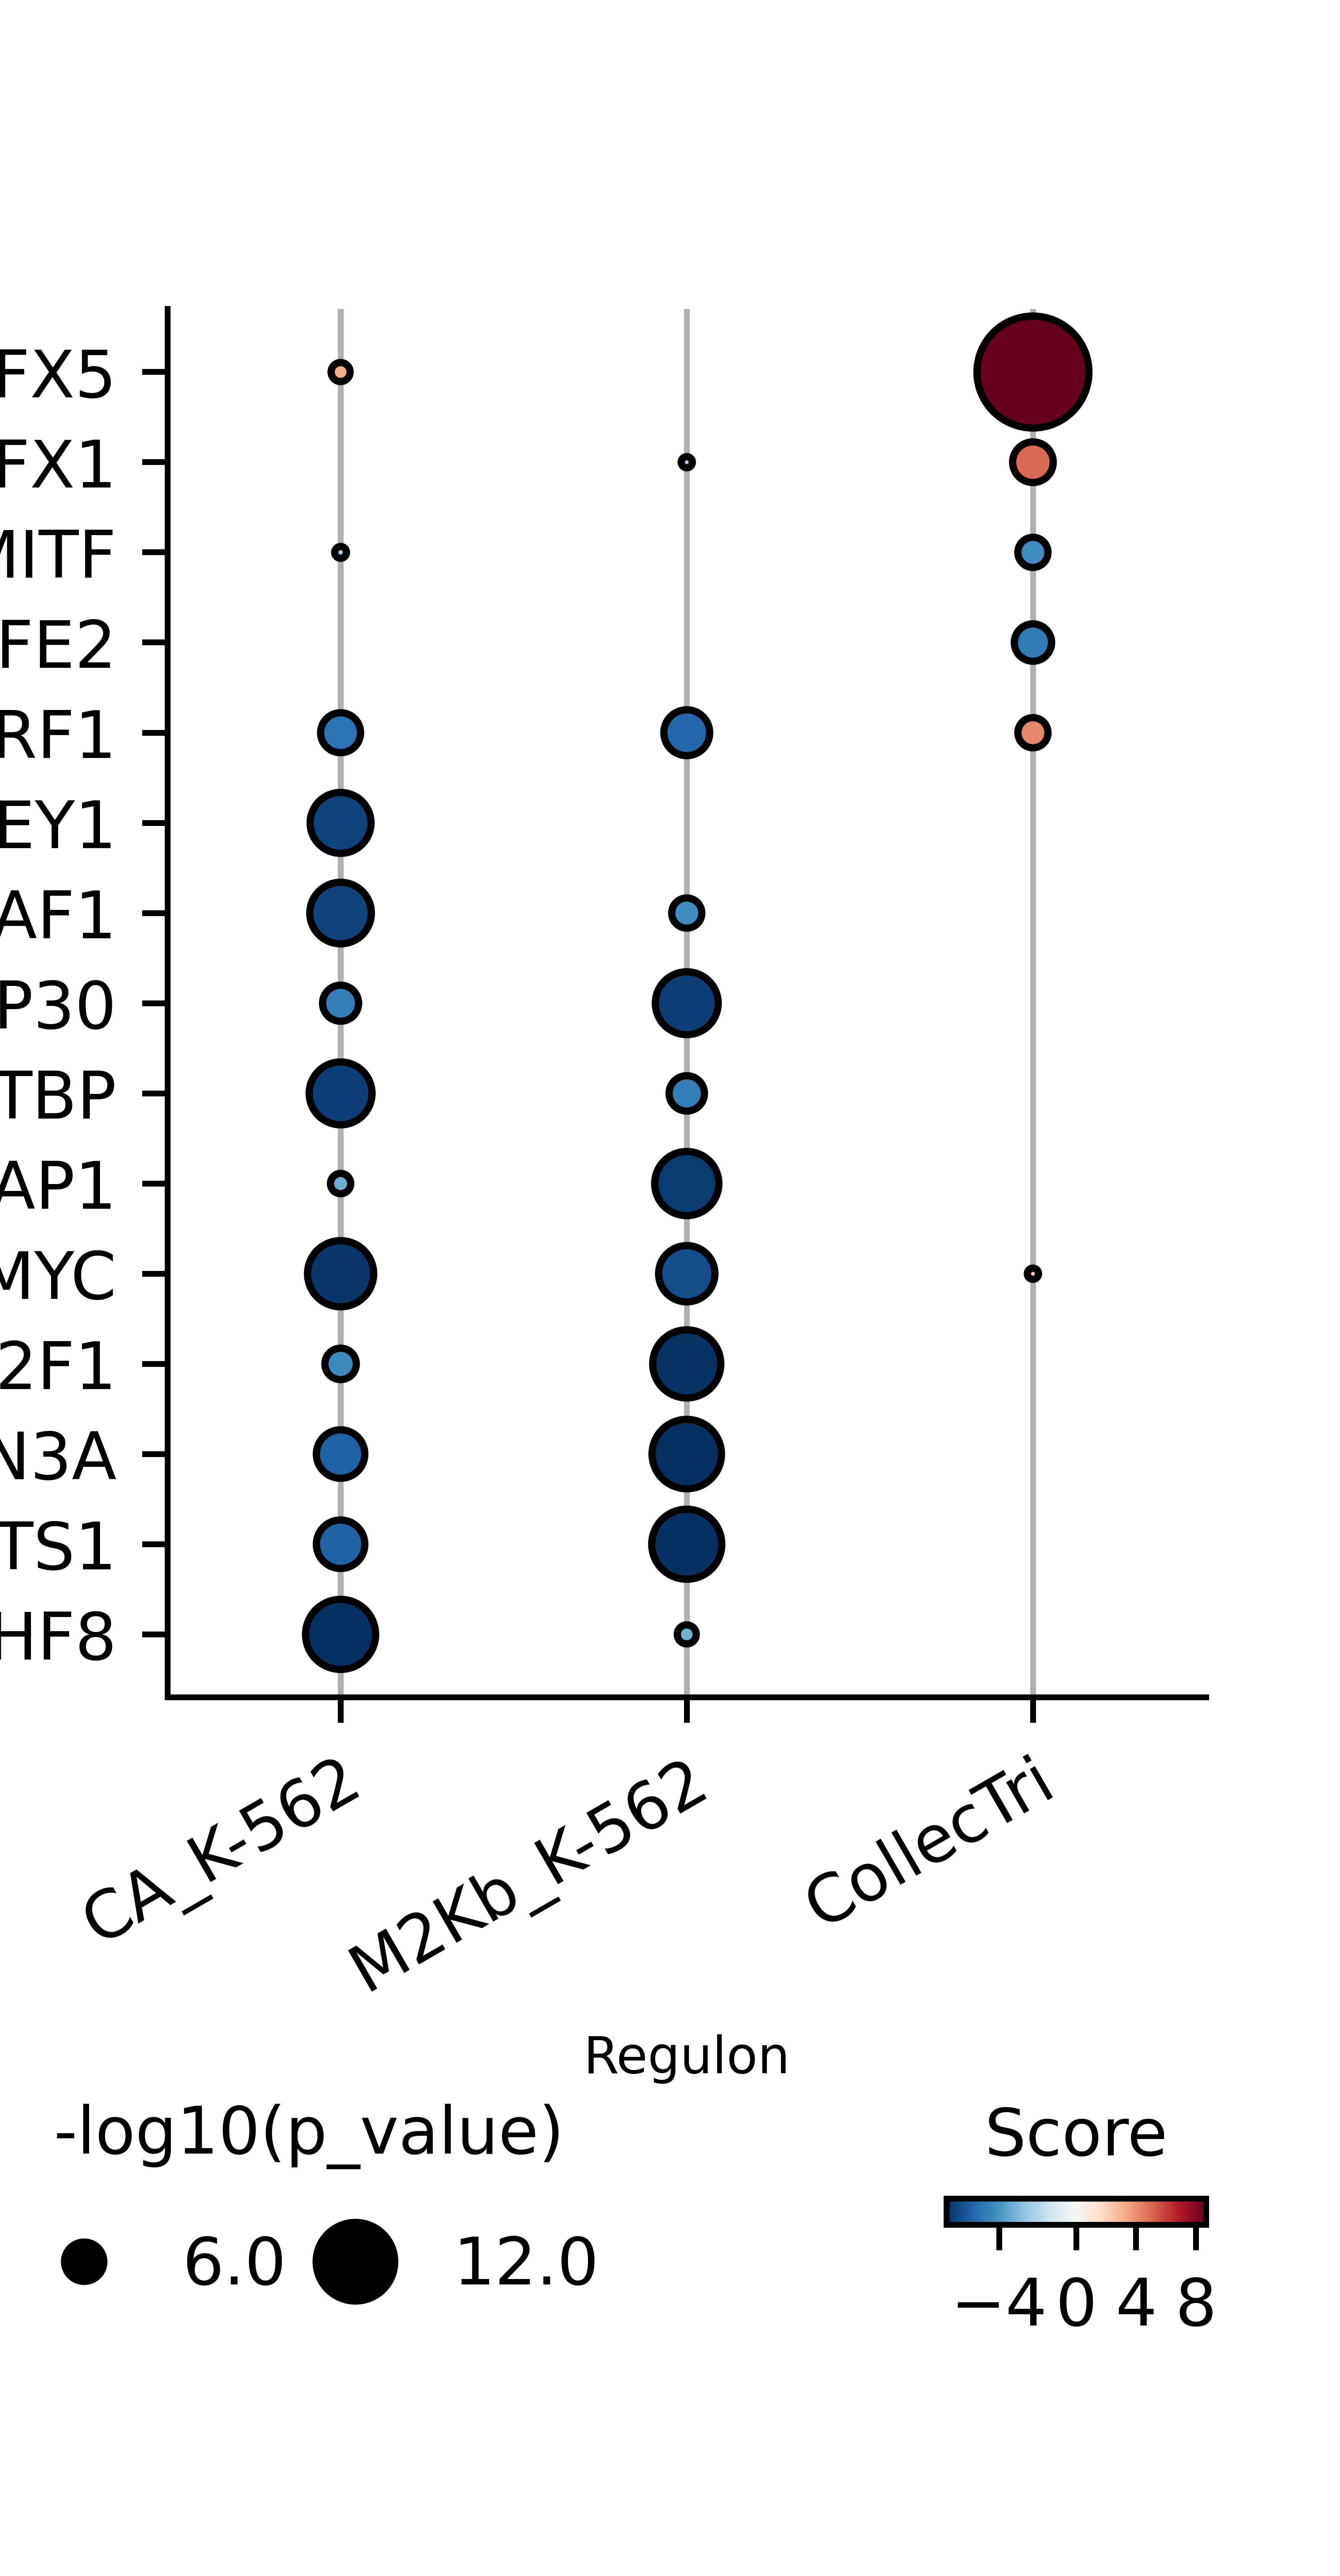

In [70]:
out = pd.DataFrame()
#interesting_tf = ["YY1", "MYB", "MYC", "SP1", "CREB1"]
interesting_tf = []
#for net in ["CollecTri", "M2Kb_K-562", "M2Kb_GM-12878", "CA_K-562", "CA_GM-12878"]:
for net in ["CollecTri", "M2Kb_K-562", "CA_K-562"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_K-562", "CA_K-562"])], scale=0.15)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_dhsc_ahsc.svg", dpi=720, format="svg")
plt.show()

In [71]:
len(megaheat[megaheat.Network == "CollecTri"].index.to_list())

27

In [72]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

ETS1, SIN3A, GTF2F1, THAP1, SAP30, BRD4, UBTF, NFYA, MYC, HCFC1, CTCFL, MAZ, YY1, E2F4, NRF1, GFI1B, NONO, HDAC1, ERG, MNT, IRF1, RB1, NFYB, MBD2, ZBTB7A, KDM5B, E2F6, BHLHE40, ELF1, MAX, GABPA, SIN3B, SP1, TBP, VEZF1, JUN, SMAD5, CREB1, MXI1, NEUROD1, USF2, CTBP1, EWSR1, SMAD1, TAF1, EGR1, JUND, E2F3, CTCF, TFDP1, SRF, ZFX, GMEB1, GATAD2B, FUS, REST, HIF1A, MTA3, ZBED1, PML, CREM, ZNF148, ZNF263, NR2F2, SREBF1, CREB3L1, HDGF, SKIL, NR4A1, PHF8, USF1, E4F1, KLF13, SMARCA4, ZNF143, TBL1XR1, PRDM10, FOS, PLAG1, ZNF395, CREB5, ESRRA, ZMIZ1, ATF7, EP300, IRF2, TCF7, ELF4, E2F7, CEBPD, MEF2A, ZHX1, NR2C2, MGA, ID3, NR2F1, FOSL1, KLF1, RREB1, PKNOX1, ELK1, RLF, KLF10, ATF1, MYBL2, POU5F1, SIRT6, SPI1, RFX1, ATF3, MIER1, ZNF281, BCOR, MEIS2, PHF20, ESRRB, GATA1, E2F1, ZNF24, ZBTB12, SMARCE1, ZBTB2, MTA2, FOXK2, RUNX1, ZEB2, SP2, CBFA2T3, ZNF76, MAFK, NFIX


In [73]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

NFE2, MITF, KLF1, MBD2, LEF1, BHLHE40, ERG, EP300, DLX4, USF2, IKZF1, SP1, MYC, MAFK, NFYB, CEBPG, YBX1, NR2C2, RELA, ATF3, MEF2A, THRA, YY1, CREB1, IRF1, RFX1, RFX5


In [74]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

ETS1, SIN3A, GTF2F1, THAP1, SAP30, BRD4, UBTF, NFYA, MYC, HCFC1, CTCFL, MAZ, YY1, E2F4, NRF1, GFI1B, NONO, HDAC1, ERG, MNT, IRF1, RB1, NFYB, MBD2, ZBTB7A, KDM5B, E2F6, BHLHE40, ELF1, MAX, GABPA, SIN3B, SP1, TBP, VEZF1, JUN, SMAD5, CREB1, MXI1, NEUROD1, USF2, CTBP1, EWSR1, SMAD1, TAF1, EGR1, JUND, E2F3, CTCF, TFDP1, SRF, ZFX, GMEB1, GATAD2B, FUS, REST, HIF1A, MTA3, ZBED1, PML, CREM, ZNF148, ZNF263, NR2F2, SREBF1, CREB3L1, HDGF, SKIL, NR4A1, PHF8, USF1, E4F1, KLF13, SMARCA4, ZNF143, TBL1XR1, PRDM10, FOS, PLAG1, ZNF395, CREB5, ESRRA, ZMIZ1, ATF7, EP300, IRF2, TCF7, ELF4, E2F7, CEBPD, MEF2A, ZHX1, NR2C2, MGA, ID3, NR2F1, FOSL1, KLF1, RREB1, PKNOX1, ELK1, RLF, KLF10, ATF1, MYBL2, POU5F1, SIRT6, SPI1, RFX1, ATF3, MIER1, ZNF281, BCOR, MEIS2, PHF20, ESRRB, GATA1, E2F1, ZNF24, ZBTB12, SMARCE1, ZBTB2, MTA2, FOXK2, RUNX1, ZEB2, SP2, CBFA2T3, ZNF76, MAFK, NFIX


In [75]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

NFE2, MITF, KLF1, MBD2, LEF1, BHLHE40, ERG, EP300, DLX4, USF2, IKZF1, SP1, MYC, MAFK, NFYB, CEBPG, YBX1, NR2C2, RELA, ATF3, MEF2A, THRA, YY1, CREB1, IRF1, RFX1, RFX5


In [76]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_dhsc_ahsc.tsv", sep="\t", index=False)

In [77]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_dhsc_ahsc.tsv", sep="\t", index=False)

### C6 healthy vs leukemic cells single-cell DE analysis

In [78]:
adata = sc.read_h5ad("/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/data/case_study/seurat_main_cohort.h5ad")

/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/anndata/compat/__init__.py:311: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.


In [79]:
adata.obs.value_counts("status")

status
 1             37268
-2147483648    34285
 0             25126
 2              5088
Name: count, dtype: int64

In [81]:
#adata_sub = adata[(adata.obs.status == 1) & ((adata.obs.ct.isin(["HSCs & MPPs", "Erythro-myeloid progenitors", "Early erythroid progenitor ", "Early promyelocytes"])) | (adata.obs.id == 6)), :].copy()
adata_sub = adata[(adata.obs.id == 6) , :].copy()
#adata_sub = adata[(adata.obs.status == 1) & ((adata.obs.ct.isin(["HSCs & MPPs",])) | (adata.obs.id == 6)), :].copy()

adata_sub.obs.id = adata_sub.obs.id.astype("str")
adata_sub.obs.status = adata_sub.obs.status.astype("str")

In [82]:
adata_sub.obs.status.value_counts()

status
-2147483648    3584
1               460
0               230
2                25
Name: count, dtype: int64

In [84]:
sc.tl.rank_genes_groups(adata_sub, groupby="status", reference="0", use_raw=False, method="wilcoxon")
de_genes_sc = sc.get.rank_genes_groups_df(adata_sub, group="1",  pval_cutoff=1e-2)

/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
/home/marii/.conda/envs/chip_seq_reg/lib/python3.10/site-packages/numpy/core/fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)


In [85]:
de_genes_sc.sort_values("logfoldchanges")

,names,scores,logfoldchanges,pvals,pvals_adj
1563,CNN3,-3.540953,-26.705530,3.986841e-04,7.966764e-03
1748,SLC1A6,-4.848756,-6.070775,1.242380e-06,4.932476e-05
1849,CDH7,-6.104903,-5.797079,1.028630e-09,7.255267e-08
2022,AC011139.1,-14.324250,-5.224048,1.543859e-46,6.043590e-43
2028,AVP,-15.650892,-4.867310,3.275953e-55,1.282405e-50
...,...,...,...,...,...
654,OVCH1-AS1,5.034312,4.968378,4.795684e-07,2.051714e-05
212,VSTM1,7.135386,5.632230,9.651626e-13,1.148397e-10
608,SYCE1,5.173479,6.151636,2.297754e-07,1.055726e-05
480,MS4A2,5.691252,6.190923,1.261113e-08,7.175514e-07


In [86]:
de_genes = de_genes_sc
#de_genes.index = de_genes.INDEX
de_genes["leukemic"] = de_genes.logfoldchanges
de_genes.index = de_genes.names

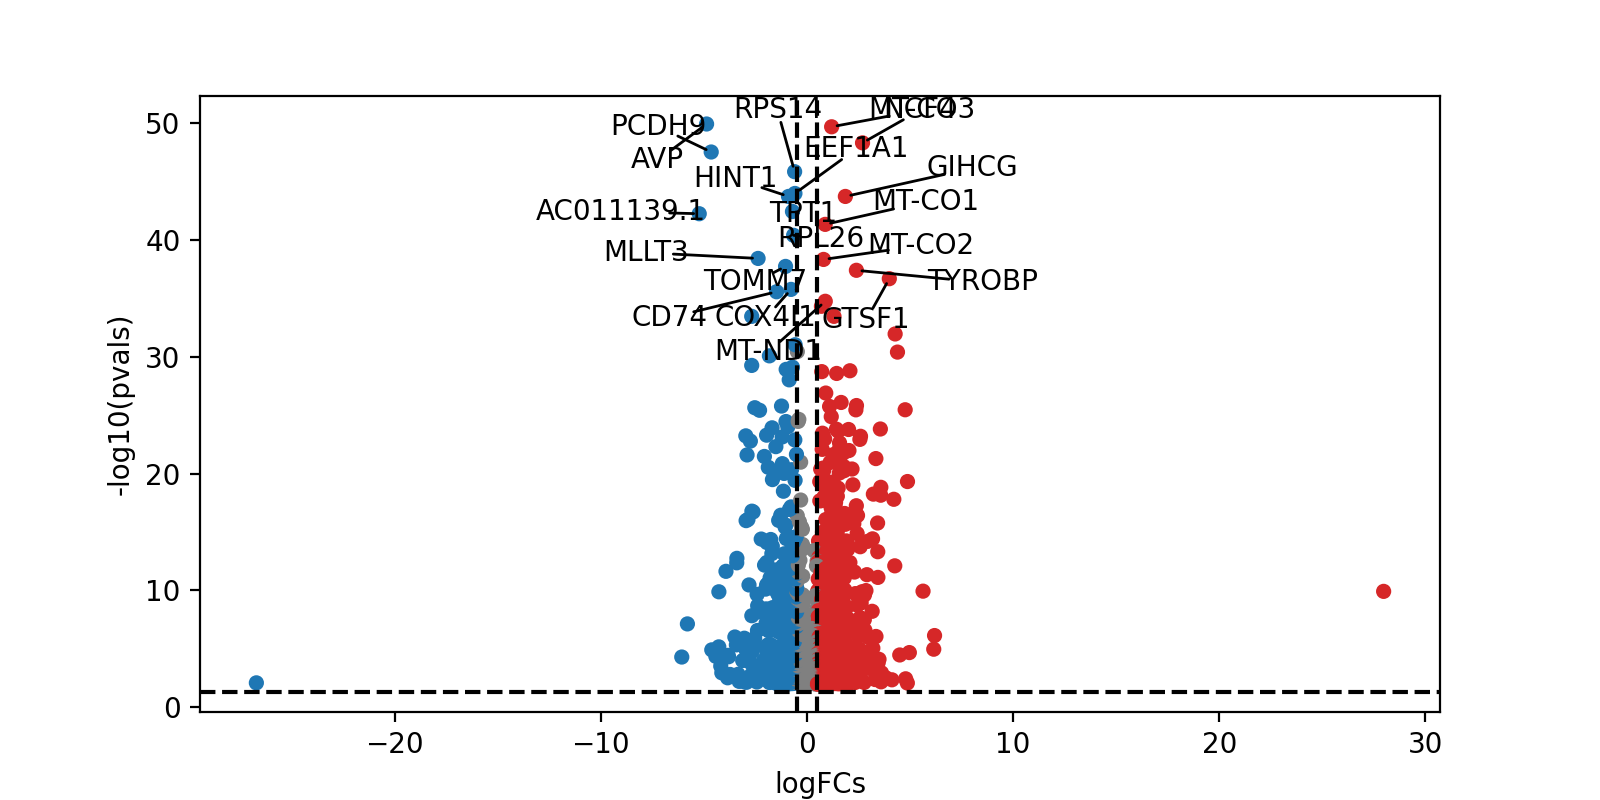

In [87]:
dc.plot_volcano_df(
    de_genes_sc,
    y='pvals_adj',
    x='logfoldchanges',
    top=20,
    figsize=(8, 4),
)

In [88]:
#enr = gp.enrich(de_genes.loc[de_genes["leukemic"].abs() > 1, :].index.to_list(), "DisGeNET")
enr = gp.enrich(de_genes.index.to_list(), "DisGeNET", )
enr.results.loc[enr.results["Adjusted P-value"] < 0.05]

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,DisGeNET,leukemia,310/1941,2.770520e-17,2.108366e-13,0,0,1.806691,68.879939,EIF4A2;APP;SPI1;RNH1;TFRC;GDE1;UBE2L6;IKZF2;RB...
1,DisGeNET,Liver carcinoma,502/3593,4.007862e-16,1.524991e-12,0,0,1.582591,56.107752,ATF1;TFRC;SPINT2;ENO1;SMC4;PREX2;TBK1;PSMD7;SC...
2,DisGeNET,melanoma,361/2454,1.604787e-14,4.070809e-11,0,0,1.641866,52.150921,ATF1;APP;RNH1;TFRC;GDE1;KEAP1;SPINT2;ENO1;RPL8...
3,DisGeNET,Stomach Neoplasms,151/835,7.549892e-13,1.436367e-09,0,0,2.032099,56.720099,IFITM1;CD81;PDCD6;PDCD5;EIF4A3;ZBTB20;HIKESHI;...
4,DisGeNET,Glioma,323/2211,1.357441e-12,1.752618e-09,0,0,1.612830,44.071255,ATF1;APP;IFITM1;TFRC;GMFG;GDE1;CISD2;KEAP1;STM...
...,...,...,...,...,...,...,...,...,...,...
263,DisGeNET,Abnormal hemoglobin finding,5/10,1.739477e-03,4.973243e-02,0,0,8.876482,56.402683,HBB;HBA2;HBA1;HBD;GATA1
264,DisGeNET,Hallermann's Syndrome,5/10,1.739477e-03,4.973243e-02,0,0,8.876482,56.402683,PANK2;HLA-B;HLA-A;HSPG2;HLA-E
265,DisGeNET,Hypoplasia of the ear cartilage,5/10,1.739477e-03,4.973243e-02,0,0,8.876482,56.402683,CD96;TP53RK;WDR73;LAGE3;OSGEP
266,DisGeNET,Infection caused by Helicobacter pylori,48/308,1.744883e-03,4.973243e-02,0,0,1.650542,10.482702,CDKN1C;DNMT1;CXCL8;HPGD;GSTP1;ODC1;FHL1;PEBP1;...


In [89]:
de_genes = pd.DataFrame(de_genes["leukemic"])

In [90]:
de_genes = de_genes.T

In [91]:
dc.check_corr(k562, mat=de_genes, source="tf", target="gene_symbol", weight=None).sort_values("corr")

,source1,source2,corr
9377,GTF2B,RBFOX2,-0.1618
10325,ELF4,FUS,-0.1499
10741,E2F1,GATAD2B,-0.1453
11168,FUS,RBFOX2,-0.1406
11242,CEBPD,RBFOX2,-0.1399
...,...,...,...
4,CREM,MAX,0.5907
3,JUND,NEUROD1,0.6049
2,CREM,MAZ,0.6062
1,CREM,NEUROD1,0.6091


In [92]:
dc.check_corr(collectri, mat=de_genes, weight=None).sort_values("corr")

,source1,source2,corr
2188,SREBF1,TP53,-0.0678
2187,NRF1,TP53,-0.0678
2236,GABPA,MYC,-0.0662
2264,JUN,NRF1,-0.0642
2283,MYC,TAL1,-0.0636
...,...,...,...
4,CTNNB1,TCF7L2,0.5266
3,KLF1,NFE2,0.5440
2,SMAD2,SMAD3,0.6025
1,USF1,USF2,0.6289


In [93]:
aml_disreg_enrich = pd.DataFrame()
aml_omim_enrich = pd.DataFrame()
aml_cosmic_enrich = pd.DataFrame()
megaheat_sc = pd.DataFrame()

In [94]:
de_genes

names,MT-CO3,NCF4,GIHCG,MT-CO1,MT-CO2,TYROBP,GTSF1,MT-ND1,H3F3A,MYL12A,...,TOMM7,MLLT3,RPL26,AC011139.1,TPT1,HINT1,EEF1A1,RPS14,PCDH9,AVP
leukemic,1.198662,2.697449,1.864951,0.885426,0.806118,2.40043,3.996359,0.890161,0.70411,1.31245,...,-1.036313,-2.369029,-0.645503,-5.224048,-0.700751,-0.891845,-0.582095,-0.596569,-4.642707,-4.86731


K562

In [95]:
tf_acts_k562, tf_pvals_k562= dc.run_ulm(de_genes, k562, source='tf', target='gene_symbol', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [96]:
mask = tf_pvals_k562 < 0.05
active_tfs_k562 = tf_acts_k562.loc["leukemic", pd.DataFrame(tf_acts_k562 * mask).sum(axis=0) != 0].index.to_list()

In [97]:
active_tfs_k562

['ARID1B',
 'ASH1L',
 'ATF1',
 'ATF7',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CBFA2T3',
 'CEBPD',
 'CREB1',
 'CREB3L1',
 'CREM',
 'CTBP1',
 'CTCF',
 'CTCFL',
 'E2F1',
 'E2F3',
 'E2F4',
 'E2F6',
 'E2F7',
 'E2F8',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'EP300',
 'ERG',
 'ESRRA',
 'ETS1',
 'ETV6',
 'FOSL1',
 'FOXK2',
 'FOXM1',
 'GABPA',
 'GATA1',
 'GATA2',
 'GATAD2B',
 'GFI1B',
 'GMEB1',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HDAC3',
 'HDGF',
 'ID3',
 'IRF1',
 'IRF2',
 'JUN',
 'JUNB',
 'JUND',
 'KDM5B',
 'KLF1',
 'KLF13',
 'KLF6',
 'LDB1',
 'MAX',
 'MAZ',
 'MBD2',
 'MEF2A',
 'MIER1',
 'MNT',
 'MTA2',
 'MTA3',
 'MXI1',
 'MYC',
 'NCOA1',
 'NCOR1',
 'NEUROD1',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2F1',
 'NR2F2',
 'NR4A1',
 'NRF1',
 'PHF8',
 'PKNOX1',
 'PML',
 'POU5F1',
 'PRDM10',
 'RB1',
 'RBFOX2',
 'RCOR1',
 'REST',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SKIL',
 'SMAD1',
 'SMAD5',
 'SMARCA4',
 'SMARCE1',
 'SOX6',
 'SP1',
 'SPI1',
 'SREBF1',
 'SRF',
 'TAF1',
 'TAL1',
 'TBP',
 'TCF12',
 'TCF3',
 'TCF7L2',
 'TFDP1',
 'TR

In [98]:
tf_acts_k562.index = ["score"]
tf_pvals_k562.index = ["p_value"]
out_k562 = pd.merge(left=tf_acts_k562.T, right=tf_pvals_k562.T, left_index=True, right_index=True)
out_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_m2kb_k562_sc.tsv", sep="\t", index=False)

In [99]:
out_k562.sort_values("p_value")

,score,p_value
MYC,5.237953,1.791992e-07
BRD4,5.231511,1.854732e-07
SIN3A,5.110581,3.513180e-07
SAP30,4.912781,9.699095e-07
MNT,4.822382,1.524144e-06
...,...,...
CC2D1A,-0.061673,9.508293e-01
RFX5,0.030860,9.753841e-01
RUNX1,0.027926,9.777238e-01
SIRT6,-0.027704,9.779008e-01


In [100]:
active_tfs_k562

['ARID1B',
 'ASH1L',
 'ATF1',
 'ATF7',
 'BCOR',
 'BHLHE40',
 'BRD4',
 'CBFA2T3',
 'CEBPD',
 'CREB1',
 'CREB3L1',
 'CREM',
 'CTBP1',
 'CTCF',
 'CTCFL',
 'E2F1',
 'E2F3',
 'E2F4',
 'E2F6',
 'E2F7',
 'E2F8',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'EP300',
 'ERG',
 'ESRRA',
 'ETS1',
 'ETV6',
 'FOSL1',
 'FOXK2',
 'FOXM1',
 'GABPA',
 'GATA1',
 'GATA2',
 'GATAD2B',
 'GFI1B',
 'GMEB1',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HDAC3',
 'HDGF',
 'ID3',
 'IRF1',
 'IRF2',
 'JUN',
 'JUNB',
 'JUND',
 'KDM5B',
 'KLF1',
 'KLF13',
 'KLF6',
 'LDB1',
 'MAX',
 'MAZ',
 'MBD2',
 'MEF2A',
 'MIER1',
 'MNT',
 'MTA2',
 'MTA3',
 'MXI1',
 'MYC',
 'NCOA1',
 'NCOR1',
 'NEUROD1',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2F1',
 'NR2F2',
 'NR4A1',
 'NRF1',
 'PHF8',
 'PKNOX1',
 'PML',
 'POU5F1',
 'PRDM10',
 'RB1',
 'RBFOX2',
 'RCOR1',
 'REST',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SKIL',
 'SMAD1',
 'SMAD5',
 'SMARCA4',
 'SMARCE1',
 'SOX6',
 'SP1',
 'SPI1',
 'SREBF1',
 'SRF',
 'TAF1',
 'TAL1',
 'TBP',
 'TCF12',
 'TCF3',
 'TCF7L2',
 'TFDP1',
 'TR

In [101]:
enr = gp.enrich(active_tfs_k562, "OMIM_Expanded")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_m2kb_k562_dhsc_ahsc_sc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [102]:
enr = gp.enrich(active_tfs_k562, "DisGeNET")
enr.results["Network"] = "M2Kb_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_m2kb_k562_dhsc_ahsc_sc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [103]:
try:
    enr = gp.enrich(gene_list=active_tfs_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "M2Kb_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_m2kb_k562_dhsc_ahsc_sc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "M2Kb_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [104]:
heat = pd.concat([tf_acts_k562.rename({"leukemic": "score"}), tf_pvals_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "M2Kb_K-562"
#heat["TFs"] = heat.index
megaheat_sc = pd.concat([megaheat_sc, heat], axis =0)
megaheat_sc

,score,p_value,Network
ADNP,1.583367,0.113494,M2Kb_K-562
ARHGAP35,-0.998175,0.318314,M2Kb_K-562
ARID1B,2.177442,0.029563,M2Kb_K-562
ARID3A,1.407635,0.159392,M2Kb_K-562
ARID3B,1.057895,0.290229,M2Kb_K-562
...,...,...,...
ZNF436,1.060150,0.289203,M2Kb_K-562
ZNF444,0.664447,0.506480,M2Kb_K-562
ZNF76,1.354124,0.175848,M2Kb_K-562
ZNF77,-0.071678,0.942865,M2Kb_K-562


CollecTri

In [105]:
tf_acts_ctri, tf_pvals_ctri = dc.run_ulm(de_genes, collectri, weight="weight")
#tf_pvals_ctri.loc["leukemic"] = fdrcorrection(tf_pvals_ctri.T["leukemic"])[1]

In [106]:
mask_ctri = tf_pvals_ctri < 0.05
active_tfs_ctri = tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].index.to_list()
tf_acts_ctri.loc["leukemic", pd.DataFrame(tf_acts_ctri * mask_ctri).sum(axis=0) != 0].sort_values()

RFX5     -3.505009
DLX4     -3.060128
EGR1     -2.970938
CEBPG    -2.528617
MAFK     -2.468398
RELA     -2.457523
HIF1A    -2.330709
JUN      -2.247277
NFIC     -2.228855
CREB1    -2.125986
RFX1     -2.051212
NR2C2    -2.025531
YBX1     -1.970620
SREBF1    2.050635
IRF9      2.825633
BRCA1     2.858859
GATA1     3.267212
KLF1      3.383614
NFE2      3.641812
MEF2A     3.752824
GATA2     4.133767
Name: leukemic, dtype: float32

In [107]:
tf_acts_ctri.index = ["score"]
tf_pvals_ctri.index = ["p_value"]
out_ctri = pd.merge(left=tf_acts_ctri.T, right=tf_pvals_ctri.T, left_index=True, right_index=True)
out_ctri.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_collectri_sc.tsv", sep="\t", index=False)

In [108]:
enr = gp.enrich(active_tfs_ctri, "OMIM_Expanded")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_collectri_dhsc_ahsc_sc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [109]:
enr = gp.enrich(active_tfs_ctri, "DisGeNET")
enr.results["Network"] = "CollecTri"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_collectri_dhsc_ahsc_sc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [110]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network
0,DisGeNET,Mammary Neoplasms,14/2387,5.886557e-09,0.000008,0,0,14.838601,281.200310,MEF2A;EGR1;SREBF1;JUN;DLX4;YBX1;BRCA1;NR2C2;HI...,CollecTri
1,DisGeNET,Secondary malignant neoplasm of lymph node,11/1271,1.276323e-08,0.000009,0,0,16.341984,297.043300,EGR1;JUN;CREB1;DLX4;YBX1;BRCA1;GATA2;NR2C2;HIF...,CollecTri
2,DisGeNET,"Leukemia, Myelocytic, Acute",12/1703,1.985017e-08,0.000009,0,0,14.419870,255.737160,EGR1;JUN;CREB1;DLX4;CEBPG;BRCA1;GATA2;NR2C2;HI...,CollecTri
3,DisGeNET,Aortic Valve Insufficiency,6/214,6.638772e-08,0.000023,0,0,38.021154,628.404270,SREBF1;JUN;YBX1;BRCA1;GATA2;HIF1A,CollecTri
4,DisGeNET,Breast Carcinoma,17/4963,1.038434e-07,0.000024,0,0,12.917560,207.719288,MEF2A;EGR1;NFE2;SREBF1;JUN;DLX4;YBX1;BRCA1;RFX...,CollecTri
...,...,...,...,...,...,...,...,...,...,...,...
1400,DisGeNET,"Diabetes Mellitus, Insulin-Dependent",1/956,6.426748e-01,0.644510,0,0,0.996021,0.440357,SREBF1,CollecTri
1401,DisGeNET,Poor school performance,1/985,6.539350e-01,0.655334,0,0,0.965193,0.409963,GATA1,CollecTri
1402,DisGeNET,Mental deficiency,1/1032,6.714698e-01,0.672427,0,0,0.918914,0.365991,GATA1,CollecTri
1403,DisGeNET,Mental Retardation,1/1158,7.144001e-01,0.714909,0,0,0.813397,0.273555,GATA1,CollecTri


In [111]:
try:
    enr = gp.enrich(gene_list=active_tfs_ctri, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CollecTri"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_collectri_dhsc_ahsc_sc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CollecTri"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [112]:
heat = pd.concat([tf_acts_ctri.rename({"leukemic": "score"}), tf_pvals_ctri.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CollecTri"
#heat["TFs"] = heat.index
megaheat_sc = pd.concat([megaheat_sc, heat], axis =0)
megaheat_sc

,score,p_value,Network
ADNP,1.583367,0.113494,M2Kb_K-562
ARHGAP35,-0.998175,0.318314,M2Kb_K-562
ARID1B,2.177442,0.029563,M2Kb_K-562
ARID3A,1.407635,0.159392,M2Kb_K-562
ARID3B,1.057895,0.290229,M2Kb_K-562
...,...,...,...
YBX3,0.307136,0.758771,CollecTri
YY1,-0.719999,0.471608,CollecTri
ZBED1,-0.359167,0.719508,CollecTri
ZBTB7A,1.538005,0.124204,CollecTri


chip_atlas_k562

In [113]:
tf_acts_chip_atlas_k562, tf_pvals_chip_atlas_k562 = dc.run_ulm(de_genes, chip_atlas_k562.drop_duplicates(), source='tf', target='Target_genes', weight="weight")

#tf_pvals.loc["leukemic"] = fdrcorrection(tf_pvals.T["leukemic"])[1]

In [114]:
tf_pvals_chip_atlas_k562

,ADNP,ARHGAP35,ARID1B,ARID3A,ARID3B,ARNT,ASH1L,ATF1,ATF2,ATF3,...,ZNF274,ZNF281,ZNF316,ZNF384,ZNF395,ZNF436,ZNF444,ZNF76,ZNF77,ZNF79
leukemic,0.001969,0.811001,0.00251,0.498065,0.498113,0.263022,0.054935,0.043631,0.034298,0.586665,...,0.063042,0.145911,0.309543,0.305508,0.000219,0.997747,0.173861,0.637897,0.786425,0.561553


In [115]:
mask_chip_atlas_k562 = tf_pvals_chip_atlas_k562 < 0.05

active_tfs_chip_atlas_k562 = tf_acts_chip_atlas_k562.loc["leukemic", pd.DataFrame(tf_acts_chip_atlas_k562 * mask_chip_atlas_k562).sum(axis=0) != 0].index.to_list()

In [116]:
tf_acts_chip_atlas_k562.index = ["score"]
tf_pvals_chip_atlas_k562.index = ["p_value"]
out_chip_atlas_k562 = pd.merge(left=tf_acts_chip_atlas_k562.T, right=tf_pvals_chip_atlas_k562.T, left_index=True, right_index=True)
out_chip_atlas_k562.to_csv("../data/3-tf_activity/aml_dhsc_ahsc_activity_ca_k562_sc.tsv", sep="\t", index=False)

In [117]:
active_tfs_chip_atlas_k562

['ADNP',
 'ARID1B',
 'ATF1',
 'ATF2',
 'ATF7',
 'BHLHE40',
 'BRD4',
 'CREB1',
 'CREB3L1',
 'CREBBP',
 'CREM',
 'CTBP1',
 'E2F3',
 'E2F4',
 'E2F5',
 'E2F6',
 'E2F8',
 'E4F1',
 'EGR1',
 'ELF1',
 'ELF4',
 'ESRRA',
 'ETS1',
 'ETV1',
 'EZH2',
 'FOSL1',
 'FOXM1',
 'FUS',
 'GABPA',
 'GATA1',
 'GATA2',
 'GATAD2B',
 'GMEB1',
 'GTF2B',
 'GTF2F1',
 'HCFC1',
 'HDAC1',
 'HEY1',
 'ID3',
 'IRF1',
 'IRF9',
 'JUND',
 'KDM5B',
 'KLF1',
 'LDB1',
 'MAX',
 'MAZ',
 'MBD2',
 'MGA',
 'MNT',
 'MTA3',
 'MXI1',
 'MYC',
 'NEUROD1',
 'NFIC',
 'NFYA',
 'NFYB',
 'NONO',
 'NR2C2',
 'NR2F6',
 'NR4A1',
 'NRF1',
 'PHF8',
 'PKNOX1',
 'PLAG1',
 'PML',
 'RB1',
 'RBFOX2',
 'RCOR1',
 'REST',
 'SAP30',
 'SIN3A',
 'SIN3B',
 'SIX5',
 'SKIL',
 'SMAD5',
 'SMARCA4',
 'SMARCE1',
 'SOX6',
 'SP1',
 'SPI1',
 'SRF',
 'TAF1',
 'TAL1',
 'TBP',
 'TCF12',
 'TCF3',
 'TEAD1',
 'TFDP1',
 'TRIM24',
 'TRIM28',
 'UBTF',
 'USF1',
 'USF2',
 'VEZF1',
 'YY1',
 'ZBTB7A',
 'ZEB2',
 'ZFX',
 'ZNF143',
 'ZNF24',
 'ZNF395']

In [118]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "OMIM_Expanded")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_omim_enrich_ca_k562_dhsc_ahsc_sc.tsv", sep="\t", index=False)
aml_omim_enrich = pd.concat([aml_omim_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [119]:
enr = gp.enrich(active_tfs_chip_atlas_k562, "DisGeNET")
enr.results["Network"] = "CA_K-562"
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_disgenet_enrich_ca_k562_dhsc_ahsc_sc.tsv", sep="\t", index=False)
aml_disreg_enrich = pd.concat([aml_disreg_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)

In [120]:
try:
    enr = gp.enrich(gene_list=active_tfs_chip_atlas_k562, gene_sets=cosmic_dict, background=None)
    enr.results["Network"] = "CA_K-562"
    enr.results.to_csv("../data/3-tf_disease_enrichment/aml_cosmic_enrich_ca_k562_dhsc_ahsc_sc.tsv", sep="\t", index=False)
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, enr.results.sort_values("Adjusted P-value", ascending=True).head(5)], axis=0)
except ValueError:
    enr.results["Network"] = "CA_K-562"
    aml_cosmic_enrich = pd.concat([aml_cosmic_enrich, pd.DataFrame()], axis=0)

In [121]:
heat = pd.concat([tf_acts_chip_atlas_k562.rename({"leukemic": "score"}), tf_pvals_chip_atlas_k562.rename({"leukemic": "p_value"})], axis=0).T
#heat = heat.reindex(heat.abs().sort_values("leukemic", ascending=True).index).head(5)
heat["Network"] = "CA_K-562"
#heat["TFs"] = heat.index
megaheat_sc = pd.concat([megaheat_sc, heat], axis =0)
megaheat_sc

,score,p_value,Network
ADNP,1.583367,0.113494,M2Kb_K-562
ARHGAP35,-0.998175,0.318314,M2Kb_K-562
ARID1B,2.177442,0.029563,M2Kb_K-562
ARID3A,1.407635,0.159392,M2Kb_K-562
ARID3B,1.057895,0.290229,M2Kb_K-562
...,...,...,...
ZNF436,-0.002824,0.997747,CA_K-562
ZNF444,1.360380,0.173861,CA_K-562
ZNF76,0.470712,0.637897,CA_K-562
ZNF77,0.270991,0.786425,CA_K-562


Plotting results

In [122]:
net_dict = {"CollecTri": 7, 
            "M2Kb_K-562": 2, 
            "M2Kb_MCF-7": 3, 
            "M2Kb_HepG2": 4, 
            "M2Kb_GM-12878": 8,
            "CA_K-562": 1,
            "CA_MCF-7": 0,
            "CA_HepG2": 5,
            "CA_GM-12878": 6}
okabe = [pal[1], pal[7], pal[2]]

In [123]:
aml_omim_enrich["-log10(Adj. P-value)"] = - np.log10(aml_omim_enrich["Adjusted P-value"])
aml_omim_enrich = aml_omim_enrich.loc[aml_omim_enrich["Adjusted P-value"] < 0.05]
aml_omim_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,15.000000,15.0,15.0,15.000000,15.000000,15.000000
mean,5.813635e-05,0.001373,0.0,0.0,22.689116,238.052697,3.681006
std,6.560906e-05,0.001815,0.0,0.0,12.775480,106.051989,1.112753
min,2.596427e-07,0.000009,0.0,0.0,10.444761,89.911716,2.414714
25%,4.643821e-06,0.000009,0.0,0.0,13.612348,170.015265,2.414714
50%,5.127187e-06,0.000255,0.0,0.0,15.482812,188.595416,3.593163
75%,9.991126e-05,0.003848,0.0,0.0,39.013266,358.056541,5.040795
max,1.825826e-04,0.003848,0.0,0.0,41.456250,387.675094,5.040795


In [124]:
aml_omim_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,OMIM_Expanded,gastric cancer,7/87,1.030921e-06,0.000190,0,0,15.063696,207.653922,SMAD1;KLF6;CREB1;CTBP1;IRF1;NR2F1;EP300,M2Kb_K-562,3.721957
1,OMIM_Expanded,"diabetes mellitus, type 2",7/106,3.907862e-06,0.000255,0,0,12.161001,151.435114,NEUROD1;SMAD1;TCF7L2;CREB1;CTBP1;NR2F1;EP300,M2Kb_K-562,3.593163
2,OMIM_Expanded,prostate cancer,7/107,4.160454e-06,0.000255,0,0,12.038783,149.159149,SMAD1;KLF6;CREB1;CTBP1;MXI1;NR2F1;EP300,M2Kb_K-562,3.593163
88,OMIM_Expanded,waardenburg syndrome,5/85,1.728029e-04,0.000306,0,0,10.575855,91.622424,SMAD1;CREB1;CTBP1;NR2F1;EP300,M2Kb_K-562,3.514635
89,OMIM_Expanded,albinism,5/86,1.825826e-04,0.000306,0,0,10.444761,89.911716,SMAD1;CREB1;CTBP1;NR2F1;EP300,M2Kb_K-562,3.514635
0,OMIM_Expanded,bare lymphocyte syndrome,3/83,8.684141e-05,0.003848,0,0,41.456250,387.675094,CREB1;RFX5;RELA,CollecTri,2.414714
1,OMIM_Expanded,thalassemia,3/85,9.322667e-05,0.003848,0,0,40.441057,375.312289,CREB1;GATA1;RELA,CollecTri,2.414714
2,OMIM_Expanded,coronary artery disease,3/87,9.991126e-05,0.003848,0,0,39.474206,363.605922,MEF2A;CREB1;RELA,CollecTri,2.414714
3,OMIM_Expanded,thrombocytopenia,3/87,9.991126e-05,0.003848,0,0,39.474206,363.605922,CREB1;GATA1;RELA,CollecTri,2.414714
4,OMIM_Expanded,ovarian cancer,3/89,1.069015e-04,0.003848,0,0,38.552326,352.507160,CREB1;BRCA1;RELA,CollecTri,2.414714


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new_sc.svg


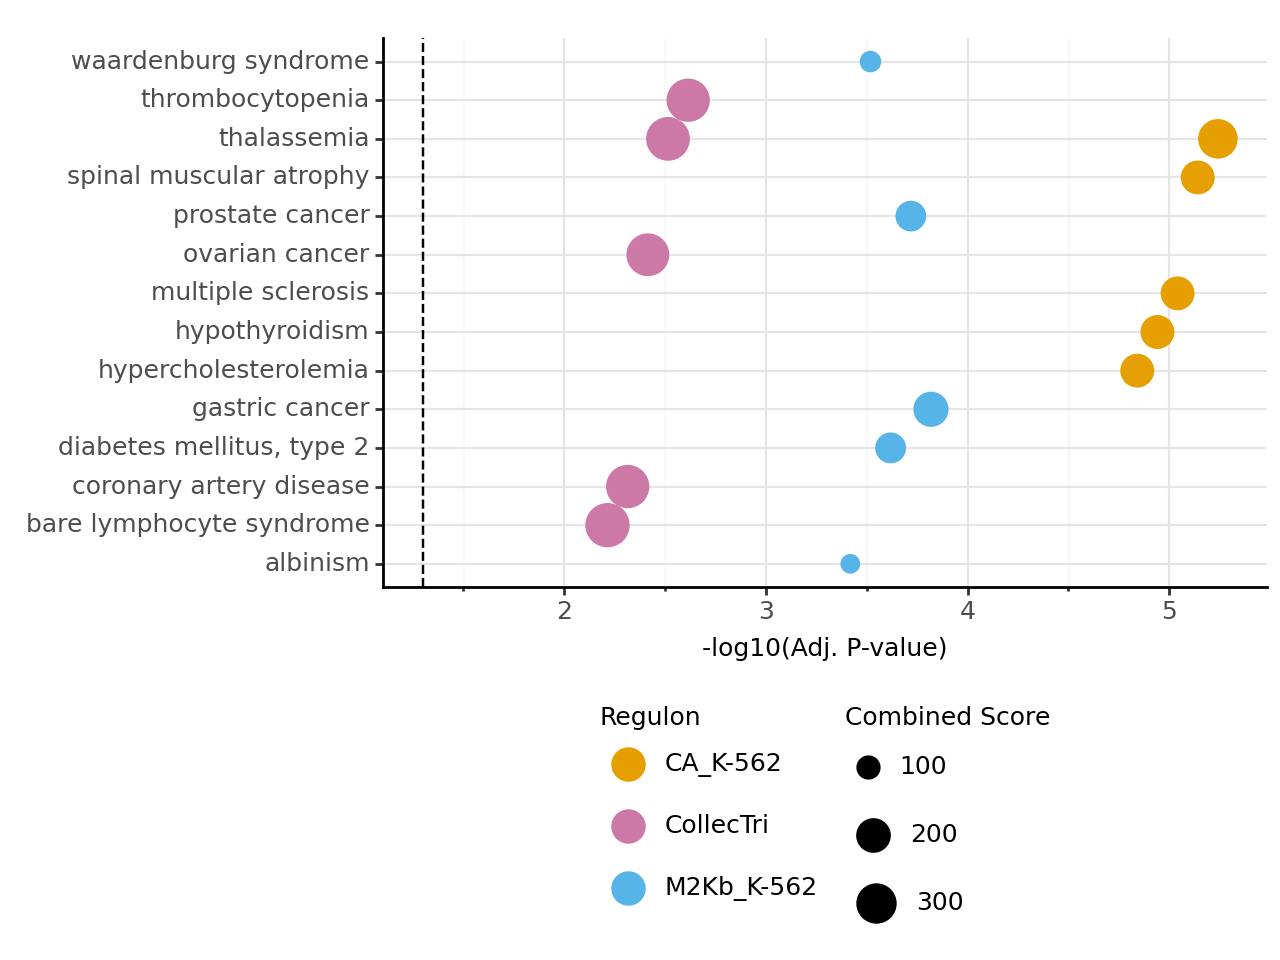

<Figure Size: (640 x 480)>

In [125]:
p = plot_enrich(aml_omim_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_omim_dhsc_ahsc_new_sc.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [126]:
aml_disreg_enrich["-log10(Adj. P-value)"] = - np.log10(aml_disreg_enrich["Adjusted P-value"])
aml_disreg_enrich = aml_disreg_enrich.loc[aml_disreg_enrich["Adjusted P-value"] < 0.05]
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,1.391541e-08,4.953554e-06,0.0,0.0,11.322274,371.341383,14.923426
std,3.032890e-08,8.488581e-06,0.0,0.0,8.150308,116.453702,7.575756
min,3.581553e-29,9.645123e-26,0.0,0.0,6.145877,207.719288,4.611697
25%,7.101580e-23,6.558217e-20,0.0,0.0,6.987033,302.168470,5.064928
50%,7.106497e-22,6.002621e-19,0.0,0.0,8.088830,343.123454,18.221659
75%,9.324894e-09,8.618391e-06,0.0,0.0,13.668715,396.757650,19.209384
max,1.038434e-07,2.445135e-05,0.0,0.0,38.021154,628.404270,25.015692


In [127]:
aml_disreg_enrich

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Network,-log10(Adj. P-value)
0,DisGeNET,Carcinogenesis,82/4065,3.581553e-29,9.645123e-26,0,0,8.180957,535.845874,RB1;ATF1;KDM5B;LDB1;CTCF;FOXM1;ETS1;PHF8;YY1;S...,M2Kb_K-562,25.015692
1,DisGeNET,Breast Carcinoma,84/4963,1.274285e-24,1.715825e-21,0,0,6.795590,373.891038,RB1;KDM5B;CTCF;FOXM1;ETS1;YY1;SIN3B;ZMIZ1;SIN3...,M2Kb_K-562,20.765527
2,DisGeNET,Malignant neoplasm of prostate,67/3239,1.077110e-22,8.768011e-20,0,0,6.415809,324.528230,RB1;KDM5B;CTCF;FOXM1;ETS1;PHF8;YY1;SIN3B;ZMIZ1...,M2Kb_K-562,19.057099
3,DisGeNET,Prostate carcinoma,66/3145,1.302341e-22,8.768011e-20,0,0,6.430277,324.039051,RB1;KDM5B;CTCF;FOXM1;ETS1;PHF8;YY1;SIN3B;ZMIZ1...,M2Kb_K-562,19.057099
4,DisGeNET,Malignant neoplasm of breast,82/5054,1.928814e-22,1.038859e-19,0,0,6.145877,307.293640,RB1;KDM5B;CTCF;FOXM1;ETS1;YY1;SIN3B;ZMIZ1;SIN3...,M2Kb_K-562,18.983443
0,DisGeNET,Mammary Neoplasms,14/2387,5.886557e-09,8.270613e-06,0,0,14.838601,281.200310,MEF2A;EGR1;SREBF1;JUN;DLX4;YBX1;BRCA1;NR2C2;HI...,CollecTri,5.082462
1,DisGeNET,Secondary malignant neoplasm of lymph node,11/1271,1.276323e-08,8.966170e-06,0,0,16.341984,297.043300,EGR1;JUN;CREB1;DLX4;YBX1;BRCA1;GATA2;NR2C2;HIF...,CollecTri,5.047393
2,DisGeNET,"Leukemia, Myelocytic, Acute",12/1703,1.985017e-08,9.296497e-06,0,0,14.419870,255.737160,EGR1;JUN;CREB1;DLX4;CEBPG;BRCA1;GATA2;NR2C2;HI...,CollecTri,5.031681
3,DisGeNET,Aortic Valve Insufficiency,6/214,6.638772e-08,2.331869e-05,0,0,38.021154,628.404270,SREBF1;JUN;YBX1;BRCA1;GATA2;HIF1A,CollecTri,4.632296
4,DisGeNET,Breast Carcinoma,17/4963,1.038434e-07,2.445135e-05,0,0,12.917560,207.719288,MEF2A;EGR1;NFE2;SREBF1;JUN;DLX4;YBX1;BRCA1;RFX...,CollecTri,4.611697


In [128]:
aml_disreg_enrich.describe()

,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,1.500000e+01,1.500000e+01,15.0,15.0,15.000000,15.000000,15.000000
mean,1.391541e-08,4.953554e-06,0.0,0.0,11.322274,371.341383,14.923426
std,3.032890e-08,8.488581e-06,0.0,0.0,8.150308,116.453702,7.575756
min,3.581553e-29,9.645123e-26,0.0,0.0,6.145877,207.719288,4.611697
25%,7.101580e-23,6.558217e-20,0.0,0.0,6.987033,302.168470,5.064928
50%,7.106497e-22,6.002621e-19,0.0,0.0,8.088830,343.123454,18.221659
75%,9.324894e-09,8.618391e-06,0.0,0.0,13.668715,396.757650,19.209384
max,1.038434e-07,2.445135e-05,0.0,0.0,38.021154,628.404270,25.015692


In [129]:
aml_disreg_enrich.loc[(aml_disreg_enrich.Network == "CollecTri"), "Combined Score"] = aml_disreg_enrich.loc[(aml_disreg_enrich.Network == "CollecTri"), "Combined Score"]/100 

/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new_sc.svg


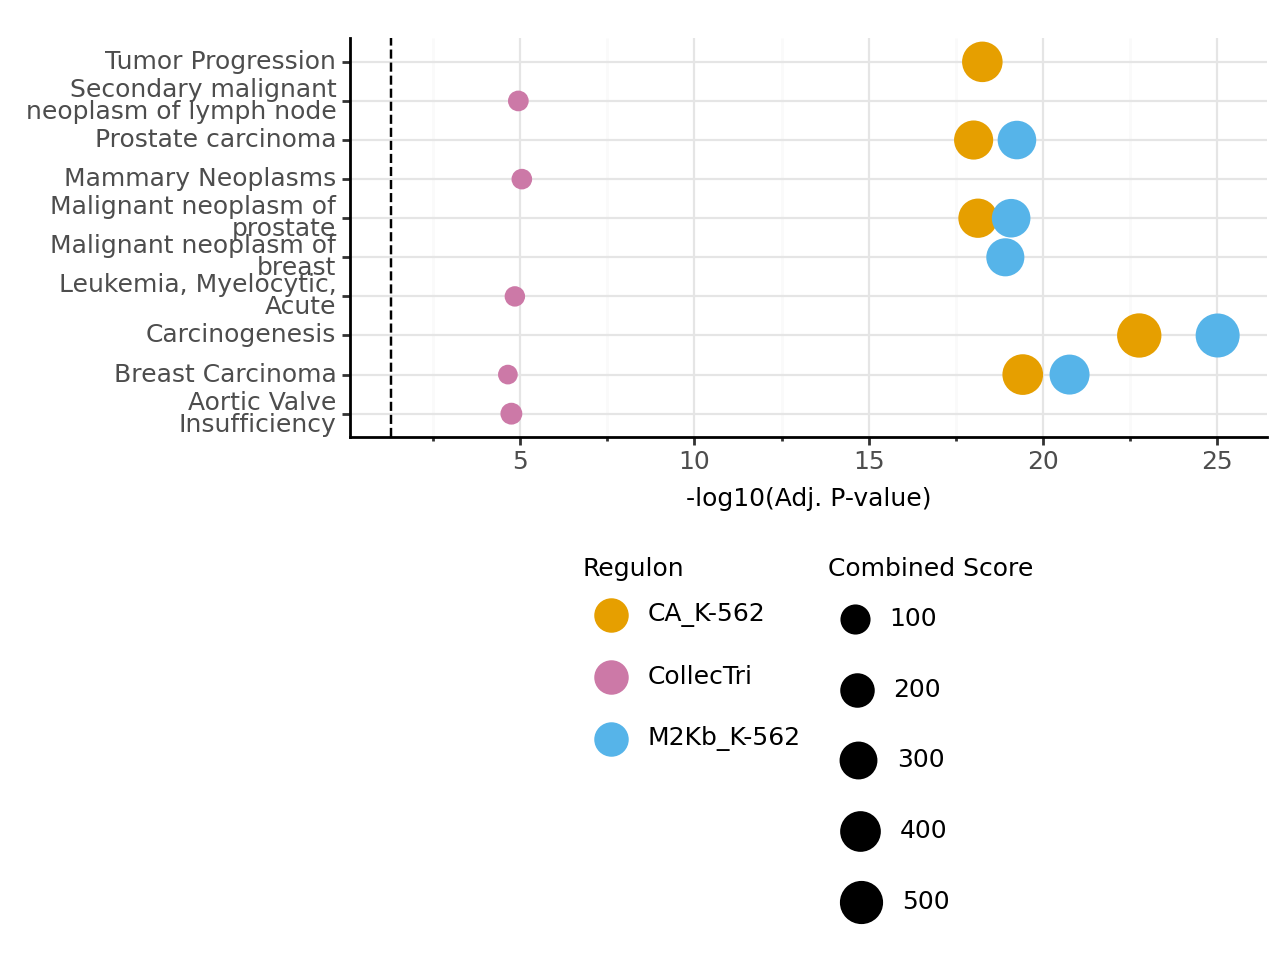

<Figure Size: (640 x 480)>

In [130]:
p = plot_enrich(aml_disreg_enrich, okabe)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_disreg_dhsc_ahsc_new_sc.svg",  width = 30, height = 150, units = "mm", dpi=720)
p

In [131]:
aml_cosmic_enrich["-log10(Adj. P-value)"] = - np.log10(aml_cosmic_enrich["Adjusted P-value"])
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.002594,0.024973,20.974627,151.647438,1.777355
std,0.002176,0.012888,11.004583,118.788060,0.600838
min,0.000027,0.000790,5.812853,34.180966,1.451040
25%,0.001191,0.021810,15.098458,87.425039,1.488383
50%,0.001896,0.029804,16.967655,88.188375,1.525727
75%,0.004162,0.032600,28.936767,193.101787,1.692661
max,0.005531,0.035396,35.971429,378.109069,3.102633


/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 30.000000000000004 x 150.0 mm image.
/home/marii/.local/lib/python3.10/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: ../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new_sc.svg


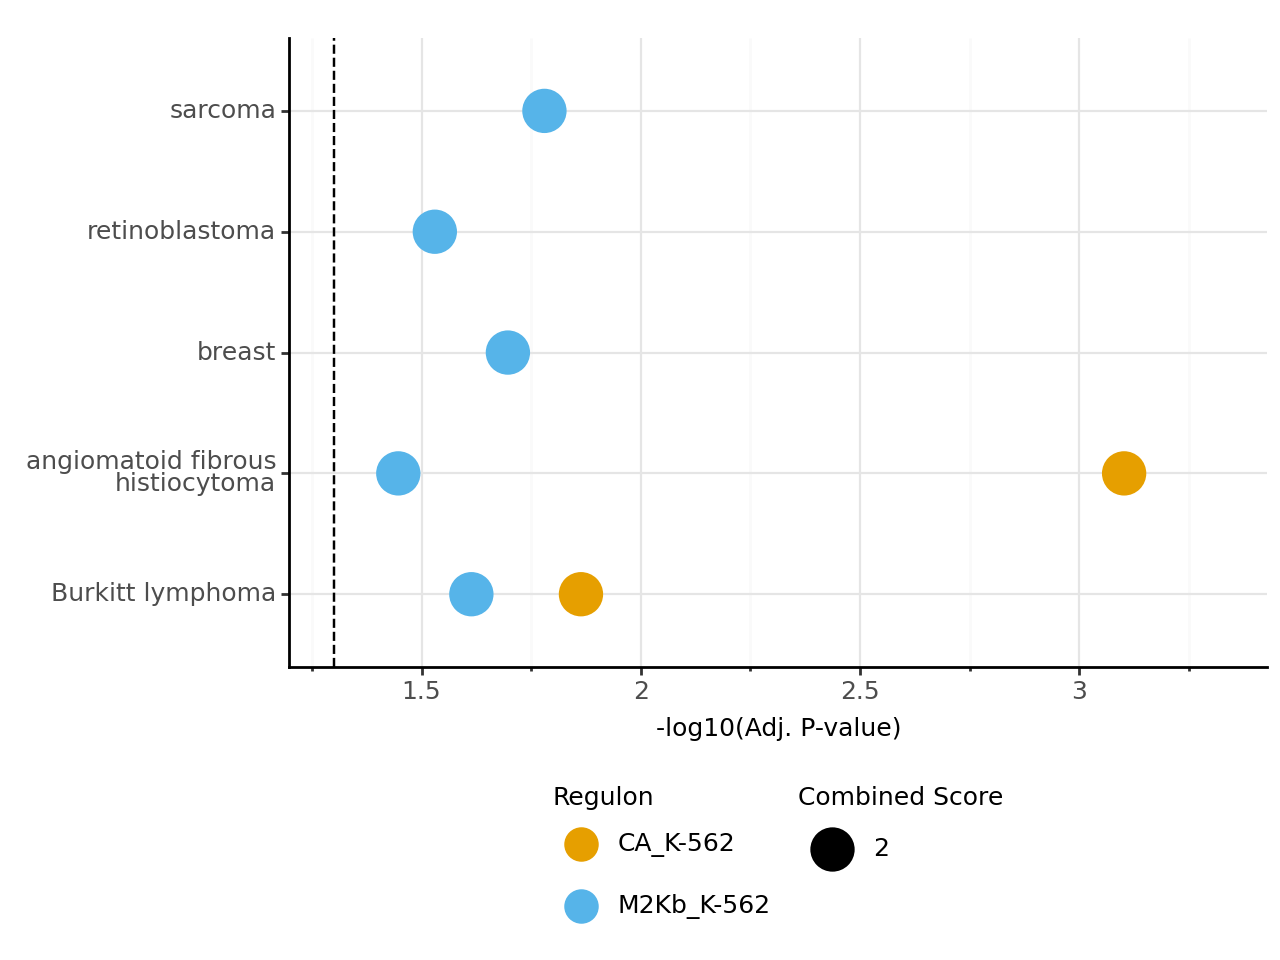

<Figure Size: (640 x 480)>

In [132]:
p = plot_enrich(aml_cosmic_enrich, [ pal[1], pal[2]], size=2)
ggsave(p, "../plots/3-tf_disease_enrichment/aml_go_enrich_cosmic_dhsc_ahsc_new_sc.svg", width = 30, height = 150, units = "mm", dpi=720)
p

In [133]:
aml_cosmic_enrich = aml_cosmic_enrich.loc[aml_cosmic_enrich["Adjusted P-value"] < 0.05]
aml_cosmic_enrich.describe()

,P-value,Adjusted P-value,Odds Ratio,Combined Score,-log10(Adj. P-value)
count,7.000000,7.000000,7.000000,7.000000,7.000000
mean,0.002594,0.024973,20.974627,151.647438,1.777355
std,0.002176,0.012888,11.004583,118.788060,0.600838
min,0.000027,0.000790,5.812853,34.180966,1.451040
25%,0.001191,0.021810,15.098458,87.425039,1.488383
50%,0.001896,0.029804,16.967655,88.188375,1.525727
75%,0.004162,0.032600,28.936767,193.101787,1.692661
max,0.005531,0.035396,35.971429,378.109069,3.102633


In [134]:
megaheat_sc.describe()

,score,p_value
count,594.000000,5.940000e+02
mean,1.567747,2.484891e-01
std,1.713368,2.955189e-01
min,-3.505009,2.797370e-10
25%,0.457328,4.227364e-03
50%,1.504890,1.080643e-01
75%,2.824977,4.705471e-01
max,6.341508,9.977473e-01


In [135]:
megaheat.to_csv("../data/3-tf_activity/aml_activity_estimates_dhsc_ahsc_sc.tsv", sep="\t", index=False)

In [136]:
megaheat_sc = megaheat_sc[megaheat_sc.p_value < 0.05].sort_values("score")
megaheat_sc["TF"] = megaheat_sc.index
megaheat_sc["log_p"] = - np.log10(megaheat_sc.p_value).round(1)
#megaheat_sc["log_p"] = megaheat_sc["log_p"].astype("str")

In [137]:
print(megaheat_sc[megaheat_sc.Network == "M2Kb_K-562"].sort_values("score").to_string())

            score       p_value     Network       TF  log_p
TRIM24   1.963973  4.966972e-02  M2Kb_K-562   TRIM24    1.3
ZNF384   1.984998  4.727925e-02  M2Kb_K-562   ZNF384    1.3
ZBTB2    1.988761  4.686188e-02  M2Kb_K-562    ZBTB2    1.3
ATF1     2.015533  4.398058e-02  M2Kb_K-562     ATF1    1.4
MIER1    2.063391  3.920251e-02  M2Kb_K-562    MIER1    1.4
ZNF316   2.116295  3.444129e-02  M2Kb_K-562   ZNF316    1.5
JUNB     2.126446  3.358668e-02  M2Kb_K-562     JUNB    1.5
FOSL1    2.130539  3.324722e-02  M2Kb_K-562    FOSL1    1.5
KLF1     2.138036  3.263313e-02  M2Kb_K-562     KLF1    1.5
CEBPD    2.144935  3.207660e-02  M2Kb_K-562    CEBPD    1.5
TFDP1    2.154755  3.129845e-02  M2Kb_K-562    TFDP1    1.5
USF2     2.163924  3.058669e-02  M2Kb_K-562     USF2    1.5
RCOR1    2.164888  3.051265e-02  M2Kb_K-562    RCOR1    1.5
NR4A1    2.167020  3.034945e-02  M2Kb_K-562    NR4A1    1.5
ARID1B   2.177442  2.956257e-02  M2Kb_K-562   ARID1B    1.5
CREB1    2.234026  2.559000e-02  M2Kb_K-

In [138]:
print(megaheat_sc[megaheat_sc.Network == "CollecTri"].sort_values("score").to_string())

           score   p_value    Network      TF  log_p
RFX5   -3.505009  0.000467  CollecTri    RFX5    3.3
DLX4   -3.060128  0.002241  CollecTri    DLX4    2.6
EGR1   -2.970938  0.003004  CollecTri    EGR1    2.5
CEBPG  -2.528617  0.011527  CollecTri   CEBPG    1.9
MAFK   -2.468398  0.013654  CollecTri    MAFK    1.9
RELA   -2.457523  0.014073  CollecTri    RELA    1.9
HIF1A  -2.330709  0.019866  CollecTri   HIF1A    1.7
JUN    -2.247277  0.024729  CollecTri     JUN    1.6
NFIC   -2.228855  0.025933  CollecTri    NFIC    1.6
CREB1  -2.125986  0.033625  CollecTri   CREB1    1.5
RFX1   -2.051212  0.040375  CollecTri    RFX1    1.4
NR2C2  -2.025531  0.042944  CollecTri   NR2C2    1.4
YBX1   -1.970620  0.048903  CollecTri    YBX1    1.3
SREBF1  2.050635  0.040431  CollecTri  SREBF1    1.4
IRF9    2.825633  0.004765  CollecTri    IRF9    2.3
BRCA1   2.858859  0.004295  CollecTri   BRCA1    2.4
GATA1   3.267212  0.001104  CollecTri   GATA1    3.0
KLF1    3.383614  0.000729  CollecTri    KLF1 

In [139]:
megaheat_sc

,score,p_value,Network,TF,log_p
RFX5,-3.505009,4.665091e-04,CollecTri,RFX5,3.3
DLX4,-3.060128,2.241427e-03,CollecTri,DLX4,2.6
EGR1,-2.970938,3.003827e-03,CollecTri,EGR1,2.5
CEBPG,-2.528617,1.152661e-02,CollecTri,CEBPG,1.9
MAFK,-2.468398,1.365392e-02,CollecTri,MAFK,1.9
...,...,...,...,...,...
IRF1,5.361677,9.184911e-08,CA_K-562,IRF1,7.0
VEZF1,5.396202,7.602817e-08,CA_K-562,VEZF1,7.1
SMAD5,5.460236,5.338644e-08,CA_K-562,SMAD5,7.3
PHF8,5.462072,5.284494e-08,CA_K-562,PHF8,7.3


/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
/crex/proj/lappalainen_lab1/users/marii/chip_seq_ann/case_studies/plot_lib.py:75: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


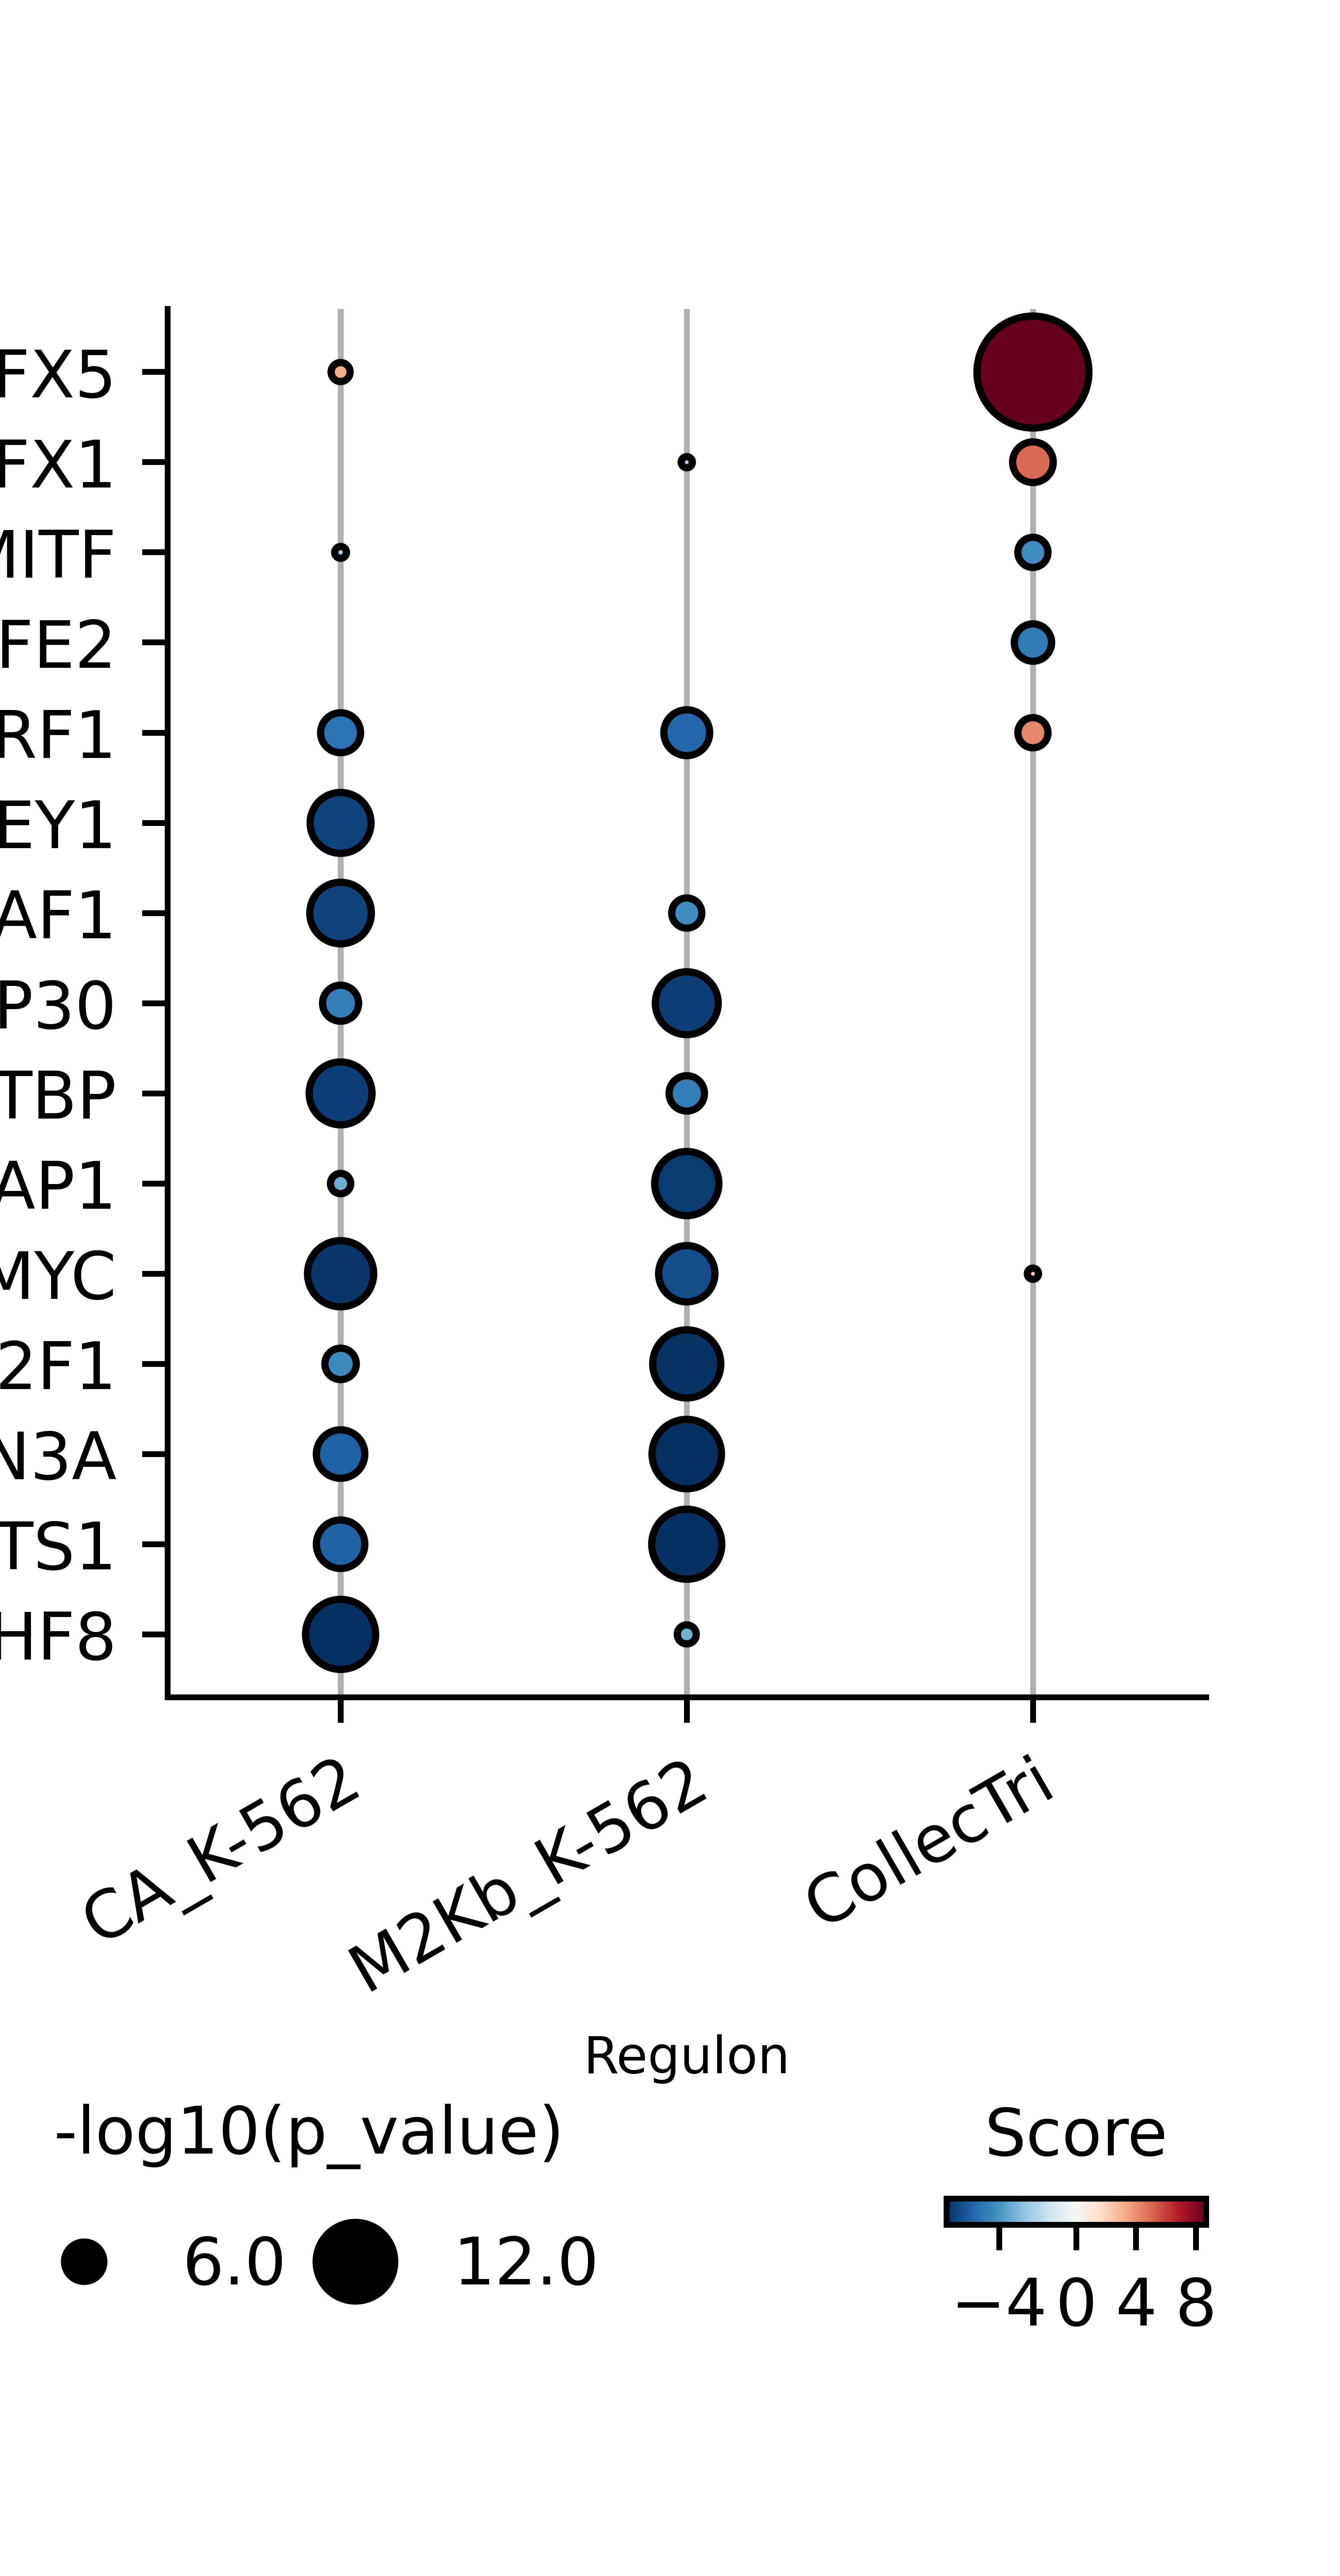

In [140]:
out = pd.DataFrame()
#interesting_tf = ["YY1", "MYB", "MYC", "SP1", "CREB1"]
interesting_tf = []
#for net in ["CollecTri", "M2Kb_K-562", "M2Kb_GM-12878", "CA_K-562", "CA_GM-12878"]:
for net in ["CollecTri", "M2Kb_K-562", "CA_K-562"]:
    mask = megaheat[megaheat.Network == net].score.abs().sort_values(ascending=False).head(5).index
    out = pd.concat([out, megaheat.loc[megaheat.TF.isin(mask) | megaheat.TF.isin(interesting_tf), :]])
plot_bubbles(out[out.Network.isin(["CollecTri", "M2Kb_K-562", "CA_K-562"])], scale=0.15)
plt.savefig("../plots/3-tf_activity/aml_activity_clustermap_dhsc_ahsc_sc.svg", dpi=720, format="svg")
plt.show()

In [141]:
len(megaheat_sc[megaheat_sc.Network == "CollecTri"].index.to_list())

21

In [142]:
print(", ".join(megaheat_sc[megaheat_sc.Network == "M2Kb_K-562"].index.to_list()))

TRIM24, ZNF384, ZBTB2, ATF1, MIER1, ZNF316, JUNB, FOSL1, KLF1, CEBPD, TFDP1, USF2, RCOR1, NR4A1, ARID1B, CREB1, NR2F1, ZNF148, ETV6, E2F1, SRF, TCF3, NCOR1, POU5F1, FOXM1, ZNF263, TAL1, TCF7L2, ASH1L, ZMIZ1, NCOA1, PRDM10, TCF12, SMAD1, SKIL, CREB3L1, GATAD2B, MTA3, ELF4, PKNOX1, NONO, CREM, ZNF143, E2F8, MTA2, HDGF, ESRRA, E2F7, HDAC3, GATA2, FOXK2, SMARCA4, KLF6, CTBP1, CTCF, CTCFL, E2F3, USF1, BCOR, ZFX, MEF2A, GATA1, RBFOX2, ZBTB7A, IRF2, HCFC1, ID3, SOX6, ZHX1, PHF8, ZEB2, JUND, NR2F2, ERG, SMARCE1, CBFA2T3, SPI1, REST, GMEB1, ATF7, EP300, ZNF24, MBD2, KLF13, SREBF1, E4F1, VEZF1, EGR1, E2F4, NFYB, E2F6, TAF1, ELF1, PML, MAZ, RB1, LDB1, GABPA, NFYA, MAX, NEUROD1, MXI1, ETS1, BHLHE40, NRF1, SP1, KDM5B, SIN3B, YY1, GTF2F1, TBP, JUN, GFI1B, IRF1, SMAD5, HDAC1, UBTF, MNT, SAP30, SIN3A, BRD4, MYC


In [143]:
print(", ".join(megaheat_sc[megaheat_sc.Network == "CollecTri"].index.to_list()))

RFX5, DLX4, EGR1, CEBPG, MAFK, RELA, HIF1A, JUN, NFIC, CREB1, RFX1, NR2C2, YBX1, SREBF1, IRF9, BRCA1, GATA1, KLF1, NFE2, MEF2A, GATA2


In [144]:
print(", ".join(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list()))

ETS1, SIN3A, GTF2F1, THAP1, SAP30, BRD4, UBTF, NFYA, MYC, HCFC1, CTCFL, MAZ, YY1, E2F4, NRF1, GFI1B, NONO, HDAC1, ERG, MNT, IRF1, RB1, NFYB, MBD2, ZBTB7A, KDM5B, E2F6, BHLHE40, ELF1, MAX, GABPA, SIN3B, SP1, TBP, VEZF1, JUN, SMAD5, CREB1, MXI1, NEUROD1, USF2, CTBP1, EWSR1, SMAD1, TAF1, EGR1, JUND, E2F3, CTCF, TFDP1, SRF, ZFX, GMEB1, GATAD2B, FUS, REST, HIF1A, MTA3, ZBED1, PML, CREM, ZNF148, ZNF263, NR2F2, SREBF1, CREB3L1, HDGF, SKIL, NR4A1, PHF8, USF1, E4F1, KLF13, SMARCA4, ZNF143, TBL1XR1, PRDM10, FOS, PLAG1, ZNF395, CREB5, ESRRA, ZMIZ1, ATF7, EP300, IRF2, TCF7, ELF4, E2F7, CEBPD, MEF2A, ZHX1, NR2C2, MGA, ID3, NR2F1, FOSL1, KLF1, RREB1, PKNOX1, ELK1, RLF, KLF10, ATF1, MYBL2, POU5F1, SIRT6, SPI1, RFX1, ATF3, MIER1, ZNF281, BCOR, MEIS2, PHF20, ESRRB, GATA1, E2F1, ZNF24, ZBTB12, SMARCE1, ZBTB2, MTA2, FOXK2, RUNX1, ZEB2, SP2, CBFA2T3, ZNF76, MAFK, NFIX


In [145]:
print(", ".join(megaheat[megaheat.Network == "CollecTri"].index.to_list()))

NFE2, MITF, KLF1, MBD2, LEF1, BHLHE40, ERG, EP300, DLX4, USF2, IKZF1, SP1, MYC, MAFK, NFYB, CEBPG, YBX1, NR2C2, RELA, ATF3, MEF2A, THRA, YY1, CREB1, IRF1, RFX1, RFX5


In [146]:
enr = gp.enrich(megaheat[megaheat.Network == "CollecTri"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_collectri_dhsc_ahsc_sc.tsv", sep="\t", index=False)

In [147]:
enr = gp.enrich(megaheat[megaheat.Network == "M2Kb_K-562"].index.to_list(), "KEGG_2021_Human")
enr.results.head(10)
enr.results.to_csv("../data/3-tf_disease_enrichment/aml_kegg_enrich_m2kb_k562_dhsc_ahsc_sc.tsv", sep="\t", index=False)